# Aphid-Ladybeetle study

In [1]:
import copy
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
from tqdm.autonotebook import tqdm
import warnings

np.seterr('warn')
warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed = 1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<ipython-input-1-dabc6be1c0a6>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 1987_Banks_et_al

data_dir = "../data/aphid_ladybird/1987_Banks_et_al/"
aphid_data = pd.read_excel(data_dir + 'aphid.xls')
ladybeetle_data = pd.read_excel(data_dir + 'ladybeetle.xls')

### 2014_Messelink

### 2017_Lin_and_Pennings

In [2]:
data_dir = "../data/2017 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

### 2018_Beltra_et_al

In [3]:
aphid_data

,Location,Time,Date,Location_code,Patch_ID,Density
0,NaN,1,NaN,NaN,NaN,2356.456977
1,NaN,2,NaN,NaN,NaN,2615.616657
2,NaN,3,NaN,NaN,NaN,2561.262823
3,NaN,4,NaN,NaN,NaN,2312.305026
4,NaN,5,NaN,NaN,NaN,3084.968851
5,NaN,6,NaN,NaN,NaN,3084.650335
6,NaN,7,NaN,NaN,NaN,2987.043890
7,NaN,8,NaN,NaN,NaN,2575.933299
8,NaN,9,NaN,NaN,NaN,2424.272800
9,NaN,10,NaN,NaN,NaN,2802.351398


In [4]:
ladybeetle_data

,Location,Time,Date,Location_code,Patch_ID,Density
0,NaN,1,NaN,NaN,NaN,7.106599
1,NaN,2,NaN,NaN,NaN,8.151265
2,NaN,3,NaN,NaN,NaN,7.103533
3,NaN,4,NaN,NaN,NaN,5.077605
4,NaN,5,NaN,NaN,NaN,4.097805
5,NaN,6,NaN,NaN,NaN,3.104325
6,NaN,7,NaN,NaN,NaN,2.083813
7,NaN,8,NaN,NaN,NaN,3.101259
8,NaN,9,NaN,NaN,NaN,4.077991
9,NaN,10,NaN,NaN,NaN,3.084606


Retrieving IC data:

In [5]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

In [6]:
aphid_ic

2356.45697690758

In [7]:
ladybeetle_ic

7.10659898477157

In [8]:
y0_BKM = aphid_ic, ladybeetle_ic

y0_BKM

(2356.45697690758, 7.10659898477157)

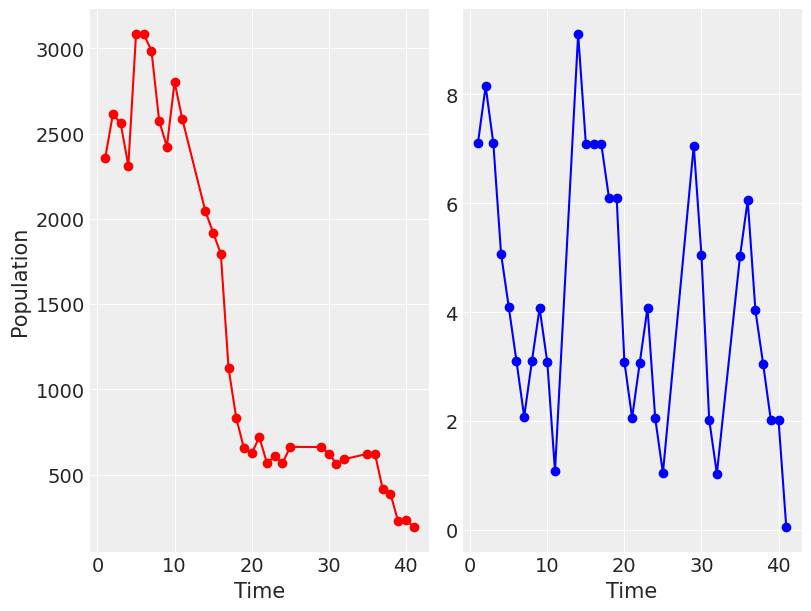

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(aphid_data.Time.values, aphid_data.Density.values, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(ladybeetle_data.Time.values, ladybeetle_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

# Prey-Predator Banks-Kareiva-Murphy A model

In [10]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def BKM_model(
    t,
    X,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    """
    Prey-Predator Banks-Kareiva-Murphy A model (BKM) python implementation.
    """
    u, v = X
    u_prime = r1 * u - r2 * u * u - p * u * v
    v_prime = i - ( e1 + e2 * np.exp( - e3 * u ) ) * v
    return u_prime, v_prime

def BKM_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    solution_ODE = solve_ivp(
        fun=BKM_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1, r2, p, i, e1, e2, e3),
        method="LSODA",
    )
    return solution_ODE

# Testing
#y0_BKM = 1000, 10
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
t0 = 0
tf = 60
days_to_forecast = 0
#time_range = np.linspace(t0, tf + days_to_forecast, tf)
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

#solution_ODE_BKM = BKM_ode_solver(y0_BKM,(t0, tf + days_to_forecast),time_range,r1=84.3076043709435,r2=3.6171452070781938e-09,p=8.42165671556821,i=0.02313343678899621,e1=5.2382389737075074e-08,e2=0.0024303746376647104,e3=4.9340194538713404e-05)
#t_computed_BKM, y_computed_BKM = solution_ODE_BKM.t, solution_ODE_BKM.y
#aphid_analytic, ladybeetle_analytic = y_computed_BKM

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [11]:
def BKM_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [12]:
from scipy import optimize

r1=46.32166847737433
r2=9.533324619539296e-09
p=6.506856453951996
i=0.03097896528819232
e1=6.774786031845174e-08
e2=0.004623799343568372
e3=5.1998548164782127e-05

denom_min = 0.7
denom_max = 1.3
bounds_BKM = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( p * denom_min ), ( p * denom_max ) ),    # p
    ( ( i * denom_min ), ( i * denom_max ) ),    # i
    ( ( e1 * denom_min ), ( e1 * denom_max ) ),  # e1
    ( ( e2 * denom_min ), ( e2 * denom_max ) ),  # e2
    ( ( e3 * denom_min ), ( e3 * denom_max ) ),  # e3
]

result_BKM = optimize.differential_evolution(
    BKM_least_squares_error_ode,
    bounds=bounds_BKM,
    args=(
        aphid_data.Time.values,
        [u_data, v_data],
        BKM_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_BKM)

differential_evolution step 1: f(x)= 5.95976e+06
parameters = [3.65028187e+01 1.12773621e-08 5.12299070e+00 3.47032530e-02
 6.62236221e-08 4.61048635e-03 4.04255953e-05]

differential_evolution step 2: f(x)= 5.95976e+06
parameters = [3.65028187e+01 1.12773621e-08 5.12299070e+00 3.47032530e-02
 6.62236221e-08 4.61048635e-03 4.04255953e-05]

differential_evolution step 3: f(x)= 5.487e+06
parameters = [3.34439616e+01 1.00778262e-08 4.68363095e+00 3.61283196e-02
 5.29703160e-08 4.85459001e-03 3.86730802e-05]

differential_evolution step 4: f(x)= 5.487e+06
parameters = [3.34439616e+01 1.00778262e-08 4.68363095e+00 3.61283196e-02
 5.29703160e-08 4.85459001e-03 3.86730802e-05]

differential_evolution step 5: f(x)= 1.48997e+06
parameters = [3.25906521e+01 1.01522752e-08 4.57555425e+00 3.23710416e-02
 5.04651262e-08 4.67608809e-03 4.49289149e-05]

differential_evolution step 6: f(x)= 1.48997e+06
parameters = [3.25906521e+01 1.01522752e-08 4.57555425e+00 3.23710416e-02
 5.04651262e-08 4.67608809

differential_evolution step 51: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 52: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 53: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 54: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 55: f(x)= 1.06959e+06
parameters = [3.49129209e+01 1.23619250e-08 4.90139012e+00 3.65913831e-02
 6.80608798e-08 5.49828593e-03 5.85176912e-05]

differential_evolution step 56: f(x)= 1.06958e+06
parameters = [3.51678715e+01 1.18081212e-08 4.93726848e+00 3.62734414e-02
 7.06184181e-08 

differential_evolution step 102: f(x)= 1.06954e+06
parameters = [3.54966619e+01 1.20101382e-08 4.98353595e+00 3.63062520e-02
 8.27024545e-08 5.45171439e-03 5.79330116e-05]

differential_evolution step 103: f(x)= 1.06953e+06
parameters = [3.55599617e+01 1.20704601e-08 4.99244336e+00 3.62538786e-02
 8.34144680e-08 5.44372638e-03 5.79118943e-05]

differential_evolution step 104: f(x)= 1.06953e+06
parameters = [3.55599617e+01 1.20704601e-08 4.99244336e+00 3.62538786e-02
 8.34144680e-08 5.44372638e-03 5.79118943e-05]

differential_evolution step 105: f(x)= 1.06953e+06
parameters = [3.55599617e+01 1.20704601e-08 4.99244336e+00 3.62538786e-02
 8.34144680e-08 5.44372638e-03 5.79118943e-05]

differential_evolution step 106: f(x)= 1.06953e+06
parameters = [3.55599617e+01 1.20704601e-08 4.99244336e+00 3.62538786e-02
 8.34144680e-08 5.44372638e-03 5.79118943e-05]

differential_evolution step 107: f(x)= 1.06953e+06
parameters = [3.55693850e+01 1.20228175e-08 4.99376922e+00 3.62508562e-02
 8.7245294

* Retrieving the calibrated parameter values:

In [13]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    p_deterministic,
    i_deterministic,
    e1_deterministic,
    e2_deterministic,
    e3_deterministic,
) = result_BKM.x

solution_ODE_BKM = BKM_ode_solver(
    y0_BKM,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_BKM.x
)
t_computed_BKM, y_computed_BKM = solution_ODE_BKM.t, solution_ODE_BKM.y
u_BKM, v_BKM = y_computed_BKM

parameters_dict = {
    "Model": "BKM",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$p$": p_deterministic,
    u"$i$": i_deterministic,
    u"$e1$": e1_deterministic,
    u"$e2$": e2_deterministic,
    u"$e3$": e3_deterministic,
}

r1,r2,p,i,e1,e2,e3, = r1_deterministic,r2_deterministic,p_deterministic,i_deterministic,e1_deterministic,e2_deterministic,e3_deterministic,

print("r1=" + str(r1) + "\n" + "r2=" + str(r2) + "\n" + "p=" + str(p) + "\n" + "i=" + str(i) + "\n" + "e1=" + str(e1) + "\n" + "e2=" + str(e2) + "\n" + "e3=" + str(e3))

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=35.56690872979918
r2=1.1713131956788192e-08
p=4.993421277966288
i=0.03624584574847937
e1=8.230520196179339e-08
e2=0.005442601935340863
e3=5.791828266406886e-05


#### Simulation

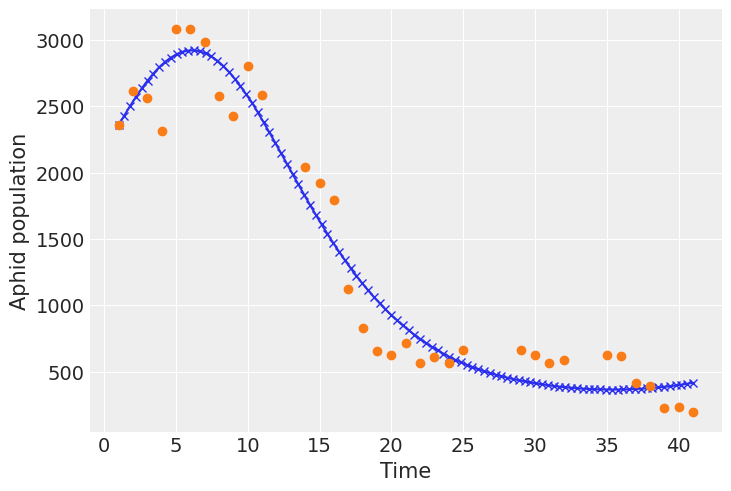

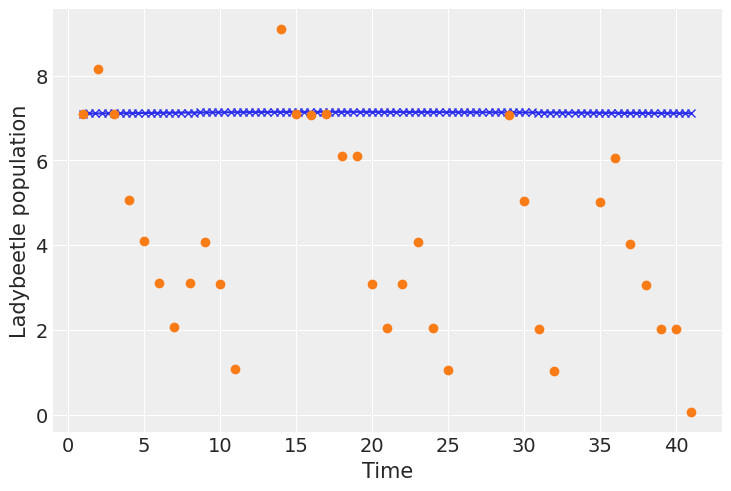

In [14]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_BKM, u_BKM, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_BKM, v_BKM, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [15]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [16]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = BKM_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        BKM_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 32/32 [00:00<00:00, 523.77it/s]


In [17]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
$r1$,0.456416
$p$,0.452806
$r2$,0.0703873
$i$,0.0201814
$e2$,0.000144198
$e3$,6.44921e-05
$e1$,1.36752e-07


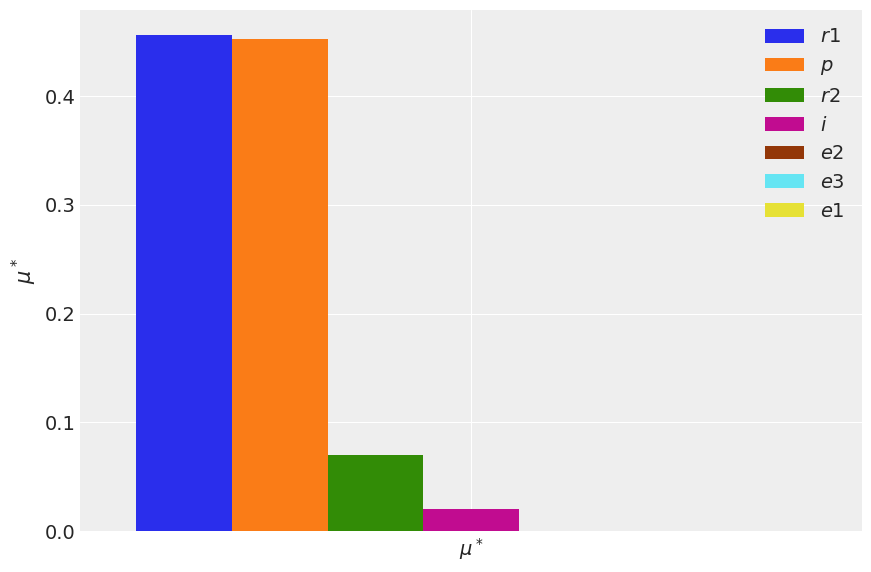

In [18]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("sensitivity_least_squares.png", dpi=300)
plt.show()

### Prey (pest) population

In [19]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [20]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKM = BKM_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKM.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 32/32 [00:00<00:00, 533.16it/s]


In [21]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 222.77it/s]


,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.500724,1.19384e-06,0.498973,8.24206e-06,1.21702e-08,0.000155839,0.000137732
1,1.808081,0.515628,0.0169545,0.46693,0.000448921,3.24388e-09,2.43187e-05,1.40609e-05
2,2.212121,0.491244,0.0856065,0.418387,0.00394579,2.68063e-08,0.000581984,0.000235322
3,2.616162,0.464737,0.139471,0.392563,0.00293685,2.08064e-08,0.000201746,9.0731e-05
4,3.020202,0.46374,0.140213,0.392292,0.00349719,2.55585e-08,0.000177649,8.01196e-05
...,...,...,...,...,...,...,...,...
94,39.383838,0.416589,0.093134,0.418442,0.0715659,5.80887e-07,0.000185216,8.35001e-05
95,39.787879,0.416083,0.0925961,0.418733,0.0723189,5.87598e-07,0.000185316,8.35468e-05
96,40.191919,0.415577,0.0920576,0.419023,0.073073,5.94318e-07,0.000185416,8.35936e-05
97,40.595960,0.415076,0.0915198,0.419311,0.0738232,6.01055e-07,0.000185519,8.36417e-05


In [22]:
df_sigmai

,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.499146,1.97836e-06,0.500336,9.85197e-06,2.09915e-08,0.000267816,0.000237636
1,1.808081,0.471129,0.0260406,0.502252,0.000542463,3.48536e-09,2.31914e-05,1.29481e-05
2,2.212121,0.417026,0.0883325,0.487458,0.00556331,4.5457e-08,0.00116267,0.00045763
3,2.616162,0.359329,0.153159,0.481728,0.00505439,4.06922e-08,0.000513447,0.000216252
4,3.020202,0.357296,0.154734,0.48141,0.00592129,4.97661e-08,0.000449924,0.000188363
...,...,...,...,...,...,...,...,...
94,39.383838,0.334405,0.07904,0.49217,0.0938669,8.71043e-07,0.000364546,0.000152507
95,39.787879,0.334282,0.0783607,0.492299,0.0945413,8.78375e-07,0.000363664,0.000152141
96,40.191919,0.334161,0.0776846,0.492427,0.0952118,8.85665e-07,0.000362784,0.000151776
97,40.595960,0.334047,0.0770137,0.492556,0.0958689,8.92935e-07,0.000361913,0.000151414


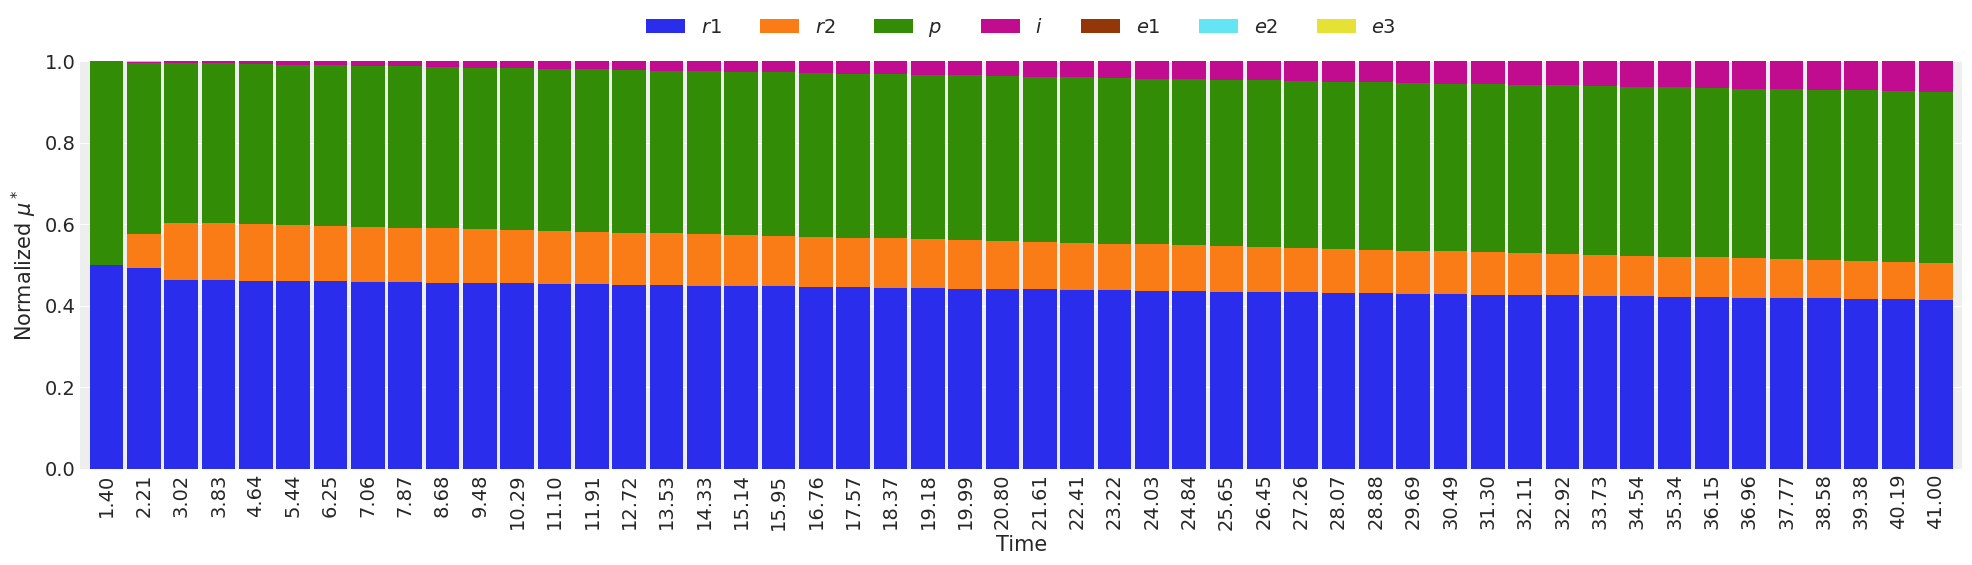

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop.png", dpi=300)
plt.show()

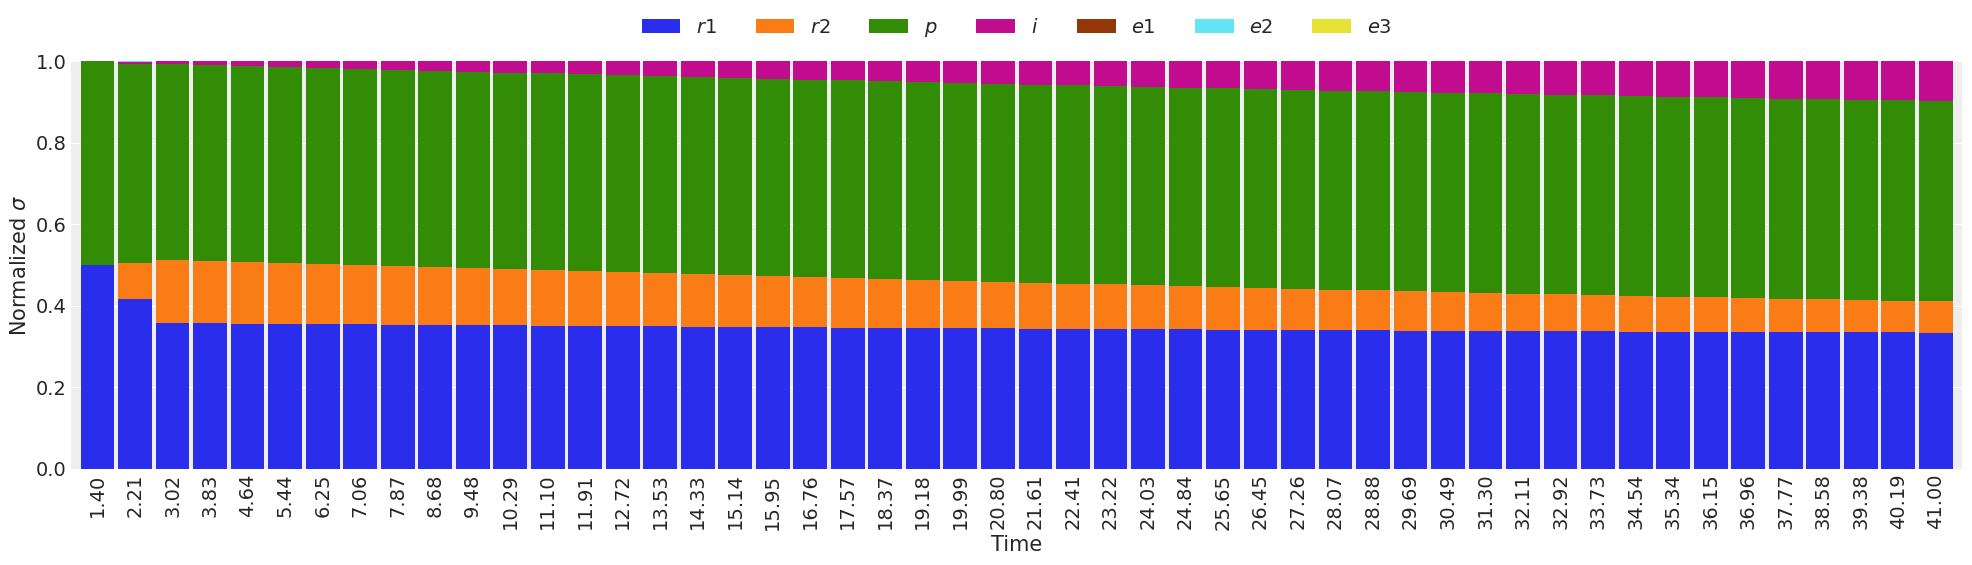

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [25]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [26]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_BKM,
    u_BKM,
    v_BKM,
    BKM_model,
    mean_values_params
)

pest_time_derivative_array

array([ 1.90021259e+02,  1.82701529e+02,  1.74468208e+02,  1.64536178e+02,
        1.52925492e+02,  1.39681488e+02,  1.24904373e+02,  1.08572791e+02,
        9.11823964e+01,  7.26404338e+01,  5.31508004e+01,  3.29894049e+01,
        1.24190591e+01, -8.28331182e+00, -2.88298160e+01, -4.89726911e+01,
       -6.84699937e+01, -8.70822873e+01, -1.04582251e+02, -1.20794584e+02,
       -1.35585754e+02, -1.48827177e+02, -1.60415466e+02, -1.70311962e+02,
       -1.78515051e+02, -1.85035396e+02, -1.89928741e+02, -1.93257592e+02,
       -1.95122379e+02, -1.95637946e+02, -1.94924216e+02, -1.93096231e+02,
       -1.90278091e+02, -1.86606967e+02, -1.82222161e+02, -1.77245833e+02,
       -1.71774805e+02, -1.65918651e+02, -1.59782560e+02, -1.53450824e+02,
       -1.46992737e+02, -1.40481231e+02, -1.34075190e+02, -1.27576150e+02,
       -1.21203343e+02, -1.14980987e+02, -1.08930152e+02, -1.03063156e+02,
       -9.73922329e+01, -9.19293538e+01, -8.66832247e+01, -8.16552903e+01,
       -7.68484142e+01, -

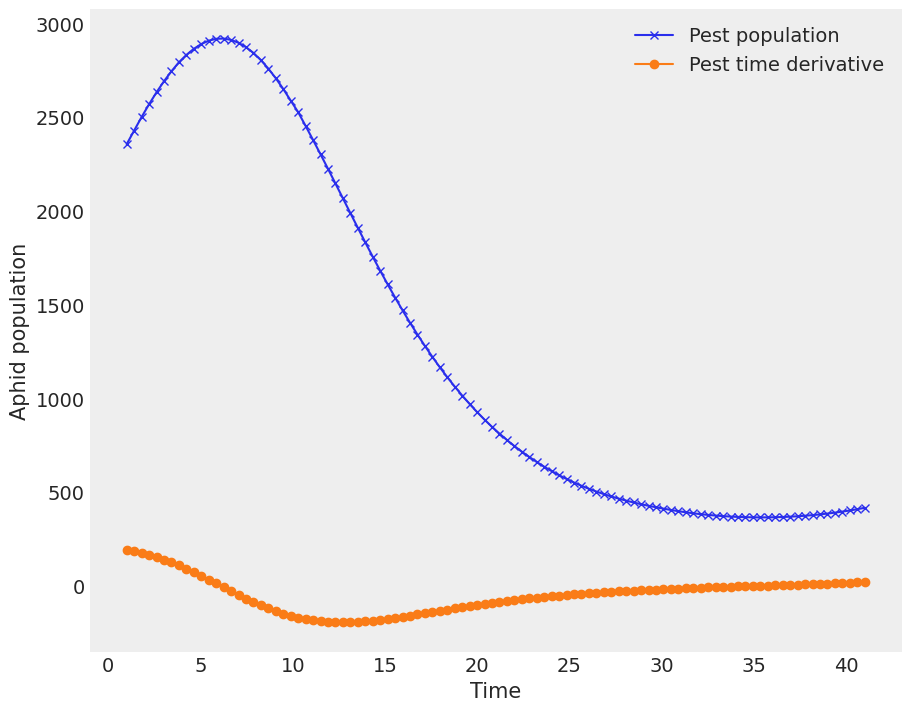

In [27]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_BKM, u_BKM, '-x', label='Pest population')
plt.plot(t_computed_BKM, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("pest_derivative.png", dpi=300)
plt.show()

In [28]:
mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [29]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKM = BKM_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKM.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        BKM_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 32/32 [00:00<00:00, 372.15it/s]


In [30]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 235.53it/s]


,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.500469,1.52667e-06,0.499279,6.47794e-06,1.13149e-08,0.000128834,0.000115195
1,1.808081,0.538855,0.383949,0.0747119,0.00206927,2.23969e-08,0.000302617,0.000112441
2,2.212121,0.417065,0.163525,0.413812,0.0049315,3.07024e-09,0.000442913,0.000223489
3,2.616162,0.403929,0.203888,0.378572,0.00800939,1.14729e-07,0.00389859,0.00170271
4,3.020202,0.277004,0.141738,0.380933,0.199728,1.47214e-06,0.000404836,0.000190233
...,...,...,...,...,...,...,...,...
94,39.383838,0.22744,0.178151,0.381638,0.212745,1.8941e-06,2.23457e-05,2.27723e-06
95,39.787879,0.227302,0.178479,0.380903,0.213294,1.90058e-06,1.76496e-05,1.99151e-06
96,40.191919,0.22775,0.179255,0.379881,0.213097,1.91114e-06,1.31568e-05,1.77532e-06
97,40.595960,0.228108,0.179951,0.379018,0.212911,1.92013e-06,8.80848e-06,1.62309e-06


In [31]:
df_sigmai

,Time,$r1$,$r2$,$p$,$i$,$e1$,$e2$,$e3$
0,1.404040,0.499418,2.52643e-06,0.500157,8.29321e-06,1.92382e-08,0.000218514,0.000195885
1,1.808081,0.523969,0.421998,0.0525595,0.00101603,1.83182e-08,0.000333576,0.000123763
2,2.212121,0.420882,0.153923,0.41783,0.0064319,3.52501e-09,0.000620474,0.000313083
3,2.616162,0.399788,0.200488,0.385316,0.00707747,8.92059e-08,0.00510248,0.00222851
4,3.020202,0.293714,0.0901147,0.428616,0.186663,1.59539e-06,0.000606453,0.000284915
...,...,...,...,...,...,...,...,...
94,39.383838,0.265454,0.120828,0.417864,0.195814,2.02721e-06,3.39497e-05,3.45902e-06
95,39.787879,0.26499,0.121035,0.417499,0.196444,2.0335e-06,2.68092e-05,3.02387e-06
96,40.191919,0.265331,0.12163,0.417183,0.195831,2.04532e-06,1.99947e-05,2.69633e-06
97,40.595960,0.265544,0.122191,0.416918,0.195329,2.05556e-06,1.33949e-05,2.46604e-06


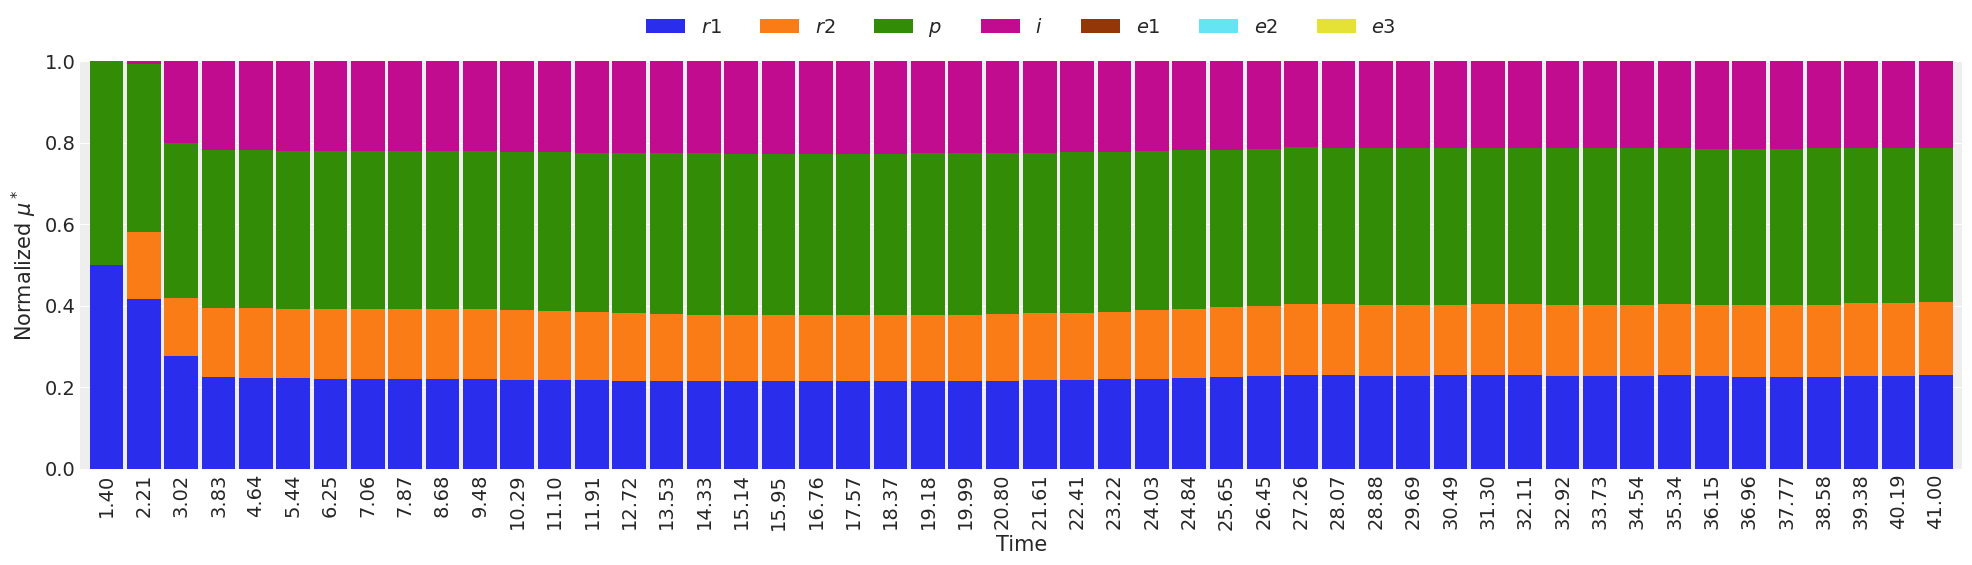

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_derivative.png", dpi=300)
plt.show()

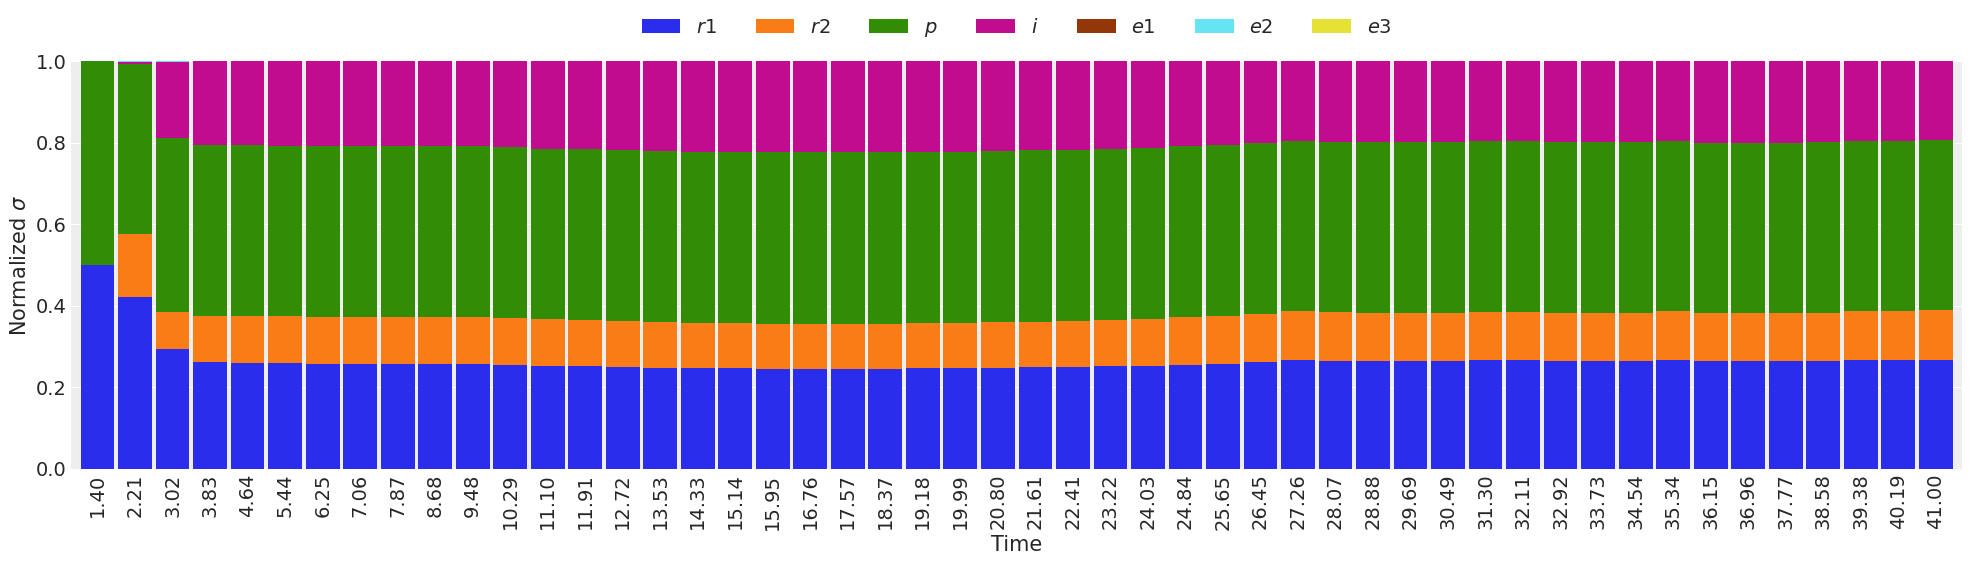

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma_derivative.png", dpi=300)
plt.show()

## Bayesian calibration

In [34]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # p
        t.dscalar,  # i
        t.dscalar,  # e1
        t.dscalar,  # e2
        t.dscalar,  # e3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def BKM_ode_wrapper(time_exp, r1, r2, p, i, e1, e2, e3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, p, i, e1, e2, e3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        BKM_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [35]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#     r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKM_model",
        BKM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#     r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKM_model",
        BKM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
    r2_ = pm.Uniform(
        "r2", 
        lower=1e-8,
        upper=1e-2
    )
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=600, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKM_model",
        BKM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, i, p, r1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 139 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 2.825 minutes


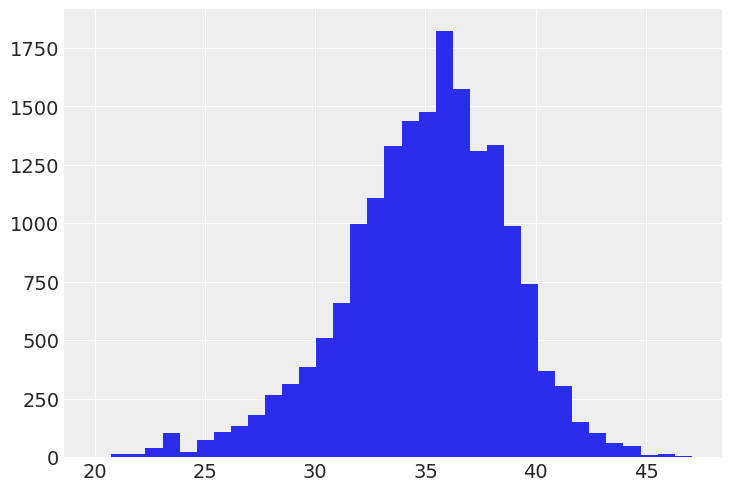

In [36]:
plt.hist(trace_calibration['r1'], bins=35)
plt.show()

In [37]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "p",
    "i"
]

100%|██████████| 4/4 [01:44<00:00, 26.02s/it]


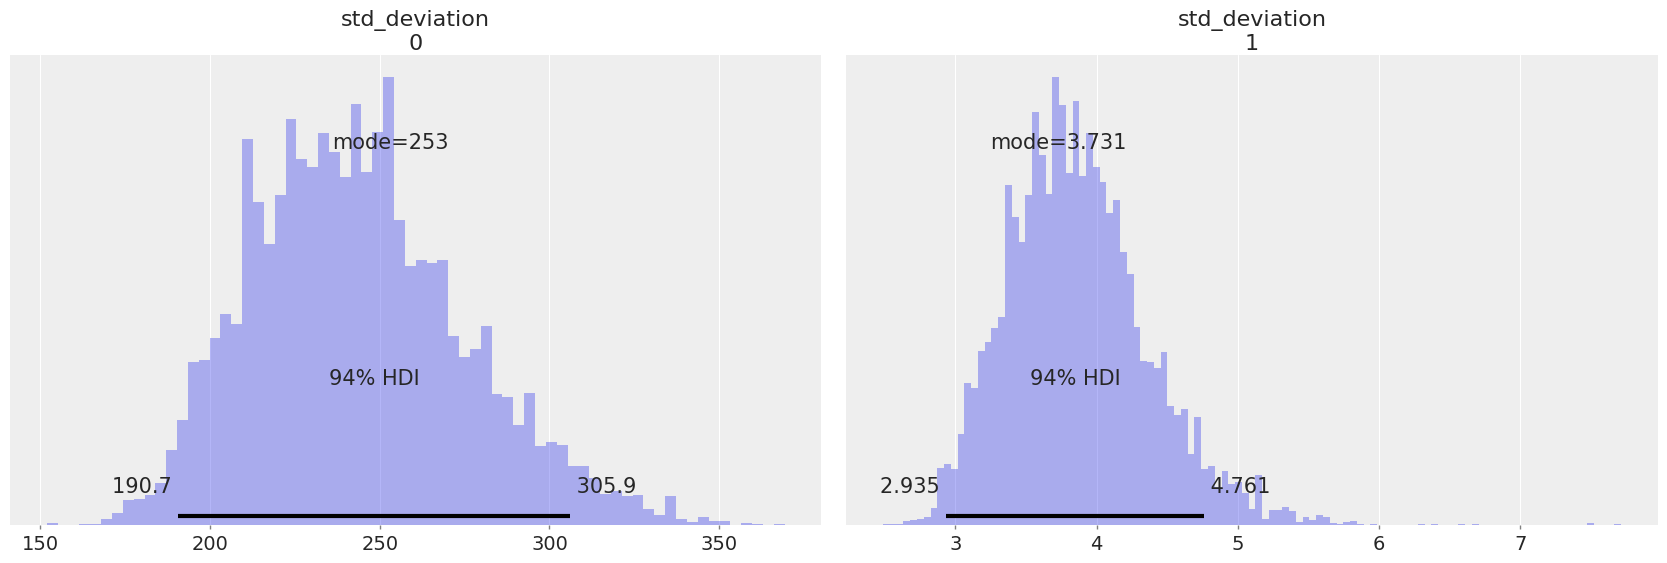

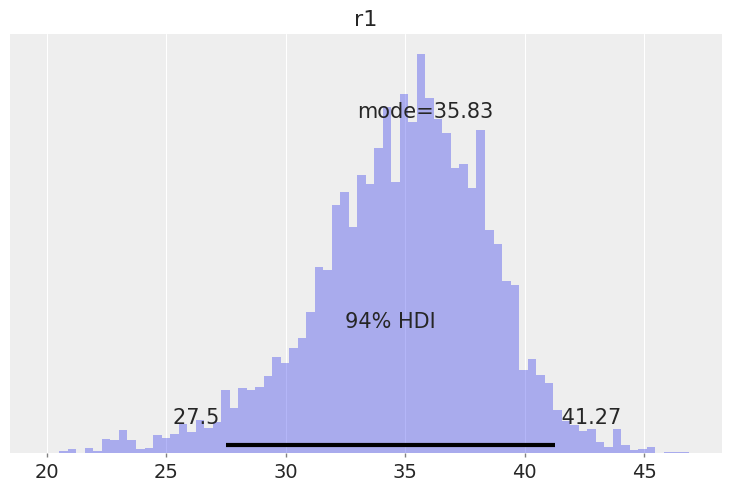

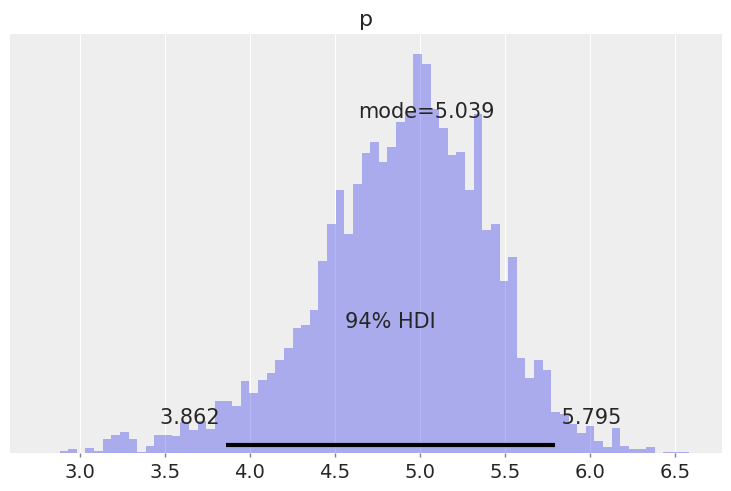

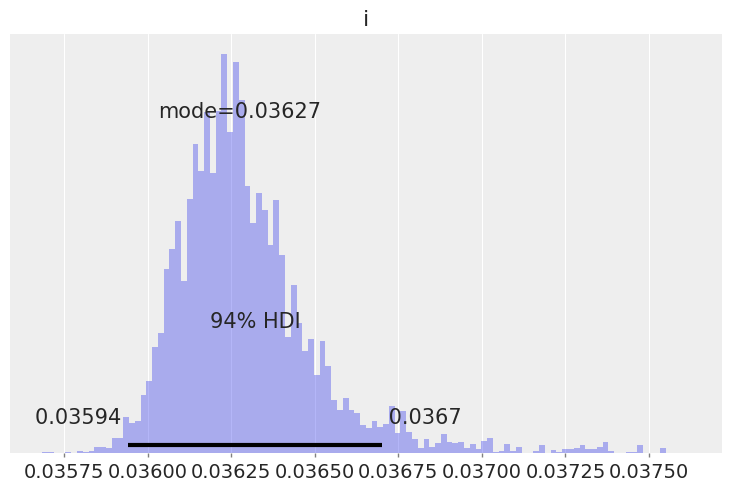

In [38]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"{variable}_posterior_cal.png")

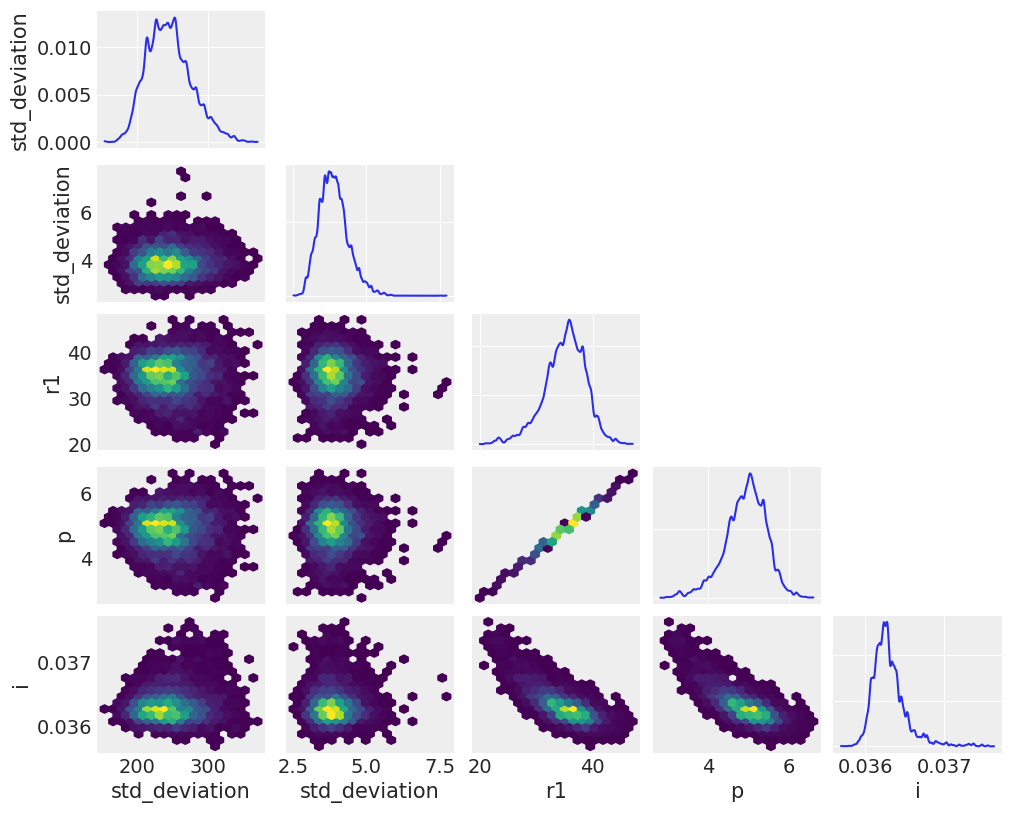

In [39]:
az.plot_pair(
    trace_calibration,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("marginals_cal.png")

In [40]:
df_stats_summary = az.summary(
    data=trace_calibration,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

,mean,sd,hdi_3%,hdi_97%
std_deviation[0],245.124898,31.483827,190.678337,305.910999
std_deviation[1],3.891902,0.498449,2.934809,4.761165
r1,35.031559,3.678614,27.504159,41.269083
p,4.918137,0.516823,3.861562,5.795359
i,0.036305,0.000218,0.035941,0.036702


Auxiliary functions to compute the Most Probable Value (MPV):

In [41]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calulating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [42]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration.csv")  # salvando em um csv para consultas

df_stats_summary

Calulating MPV from KDE for i: 100%|██████████| 4/4 [00:13<00:00,  3.48s/it]            


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],245.124898,31.483827,190.678337,305.910999,248.936189
std_deviation[1],3.891902,0.498449,2.934809,4.761165,3.785516
r1,35.031559,3.678614,27.504159,41.269083,35.883218
p,4.918137,0.516823,3.861562,5.795359,5.037637
i,0.036305,0.000218,0.035941,0.036702,0.036251


In [43]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration["BKM_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration["BKM_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration["BKM_model"], 50, axis=0)

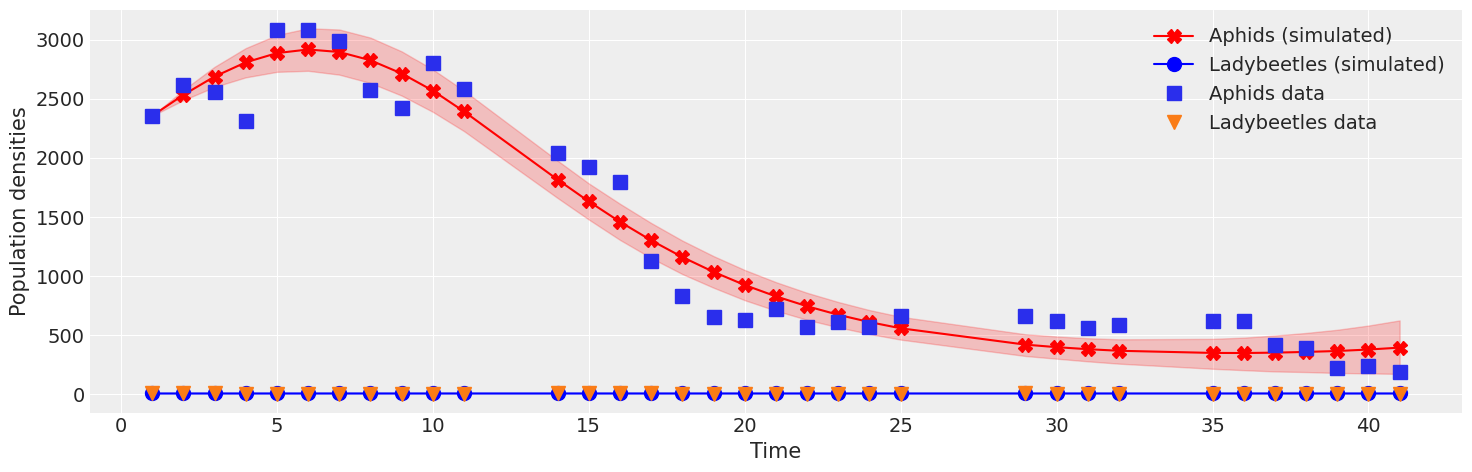

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("calibration.png", dpi=300)
plt.show()

In [45]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering i realizations: 100%|██████████| 3/3 [00:00<00:00, 1243.25it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.064 seconds


In [46]:
df_realizations

,r1,p,i
0,38.041373,5.339537,0.036241
1,38.041373,5.339537,0.036241
2,38.041373,5.339537,0.036241
3,38.041373,5.339537,0.036241
4,38.041373,5.339537,0.036241
...,...,...,...
17995,37.508977,5.266484,0.036051
17996,35.644748,5.004708,0.036222
17997,35.644748,5.004708,0.036222
17998,35.644748,5.004708,0.036222


# Prey-Predator logistic Lotka-Volterra

In [47]:
@jit(nopython=True)
def LLV_model(
    t,
    X,
    r=1,
    K=10,
    a=1,
    ef=1,
    m=1,
):
    """
    Prey-Predator logistic Lotka-Volterra (LLV) python implementation.
    """
    u, v = X
    u_prime = r * u * ( 1 - u / K ) - a * u * v
    v_prime = ef * a * u * v - m * v
    return u_prime, v_prime

def LLV_ode_solver(
    y0,
    t_span,
    t_eval,
    r=1,
    K=10,
    a=1,
    ef=1,
    m=1,
):
    solution_ODE = solve_ivp(
        fun=LLV_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r, K, a, ef, m),
        method="Radau",
    )
    return solution_ODE

## Deterministic calibration

In [48]:
def LLV_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

In [49]:
def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

bounds_LLV = [
    (1e-10, 1),  # r
    (1e-10, 5),  # K
    (1e-10, 1),  # a
    (1e-10, 5),  # ef
    (1e-10, 5),  # m
]

result_LLV = optimize.differential_evolution(
    LLV_least_squares_error_ode,
    bounds=bounds_LLV,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        LLV_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed=seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_LLV)

differential_evolution step 1: f(x)= 4.61554e+07
parameters = [1.37125069e-01 3.80587704e+00 1.66183293e-03 3.50743299e+00
 1.44304224e+00]

differential_evolution step 2: f(x)= 4.61554e+07
parameters = [1.37125069e-01 3.80587704e+00 1.66183293e-03 3.50743299e+00
 1.44304224e+00]

differential_evolution step 3: f(x)= 4.60534e+07
parameters = [0.07565095 3.19003281 0.0047591  3.46479148 2.48432648]

differential_evolution step 4: f(x)= 4.60534e+07
parameters = [0.07565095 3.19003281 0.0047591  3.46479148 2.48432648]

differential_evolution step 5: f(x)= 4.60534e+07
parameters = [0.07565095 3.19003281 0.0047591  3.46479148 2.48432648]

differential_evolution step 6: f(x)= 4.58233e+07
parameters = [0.05821569 4.11307647 0.00522252 1.23428319 4.23625294]

differential_evolution step 7: f(x)= 4.50784e+07
parameters = [2.30786180e-02 3.74687736e+00 3.29447033e-03 7.12991601e-01
 2.00419999e+00]

differential_evolution step 8: f(x)= 4.50784e+07
parameters = [2.30786180e-02 3.74687736e+00 3.29

differential_evolution step 60: f(x)= 6.63718e+06
parameters = [6.79822064e-05 2.94849316e+00 1.50130897e-06 1.14392936e+00
 3.15277489e-02]

differential_evolution step 61: f(x)= 6.63521e+06
parameters = [6.80629361e-05 3.04962204e+00 1.79205466e-06 3.16202595e-01
 3.08526922e-02]

differential_evolution step 62: f(x)= 6.63521e+06
parameters = [6.80629361e-05 3.04962204e+00 1.79205466e-06 3.16202595e-01
 3.08526922e-02]

differential_evolution step 63: f(x)= 6.63421e+06
parameters = [6.58089562e-05 2.93358883e+00 3.40380744e-06 6.90000628e-01
 3.07359900e-02]

differential_evolution step 64: f(x)= 6.63421e+06
parameters = [6.58089562e-05 2.93358883e+00 3.40380744e-06 6.90000628e-01
 3.07359900e-02]

differential_evolution step 65: f(x)= 6.63359e+06
parameters = [5.84996177e-05 2.61342031e+00 3.99605799e-06 1.68836623e-01
 2.66801640e-02]

differential_evolution step 66: f(x)= 6.63321e+06
parameters = [5.89126311e-05 2.63400139e+00 1.19106278e-05 7.35988796e-02
 2.78267593e-02]

differ

differential_evolution step 118: f(x)= 5.34323e+06
parameters = [7.57562935e-09 1.73047465e-02 3.61557943e-03 6.98392837e-03
 1.70299207e-02]

differential_evolution step 119: f(x)= 5.30232e+06
parameters = [1.75760478e-09 1.56525014e-02 3.67577338e-03 6.74357398e-03
 1.71215011e-02]

differential_evolution step 120: f(x)= 5.27176e+06
parameters = [6.00321143e-09 1.34924760e-02 3.72742473e-03 6.58591653e-03
 1.81687267e-02]

differential_evolution step 121: f(x)= 5.24397e+06
parameters = [5.81712073e-09 1.02783423e-02 3.79778694e-03 6.42540007e-03
 1.89936534e-02]

differential_evolution step 122: f(x)= 5.21395e+06
parameters = [3.24165850e-09 8.60645978e-03 3.86205395e-03 6.11913207e-03
 1.94675966e-02]

differential_evolution step 123: f(x)= 5.18415e+06
parameters = [1.28357702e-09 6.33236063e-03 3.94013729e-03 6.09868578e-03
 2.03395114e-02]

differential_evolution step 124: f(x)= 5.15825e+06
parameters = [4.43627413e-10 1.38709015e+00 4.12004791e-03 5.45469781e-03
 2.20126319e-02]


In [50]:
result_LLV.x

array([2.48145873e-10, 3.72209406e+00, 4.05452316e-03, 1.08451130e-02,
       5.23951033e-02])

In [51]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r_deterministic,
    K_deterministic,
    a_deterministic,
    ef_deterministic,
    m_deterministic,
) = result_LLV.x

solution_ODE_LLV = LLV_ode_solver(
    y0_BKM, 
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_LLV.x
)
t_computed_LLV, y_computed_LLV = solution_ODE_LLV.t, solution_ODE_LLV.y
u_LLV, v_LLV = y_computed_LLV

parameters_dict = {
    "Model": "PPRM",
    u"$r$": r_deterministic,
    u"$K$": K_deterministic,
    u"$a$": a_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
}

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
print(df_parameters_calibrated.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
Model &           \$r\$ &       \$K\$ &       \$a\$ &      \$ef\$ &       \$m\$ \\
\midrule
 PPRM &  2.481459e-10 &  3.722094 &  0.004055 &  0.010845 &  0.052395 \\
\bottomrule
\end{tabular}



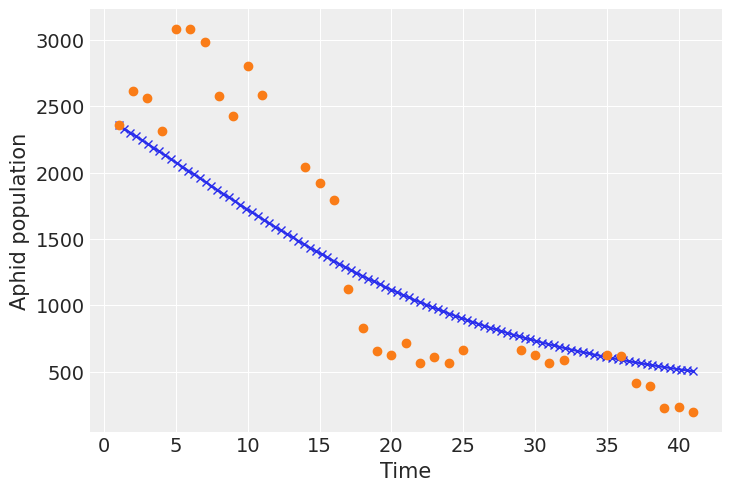

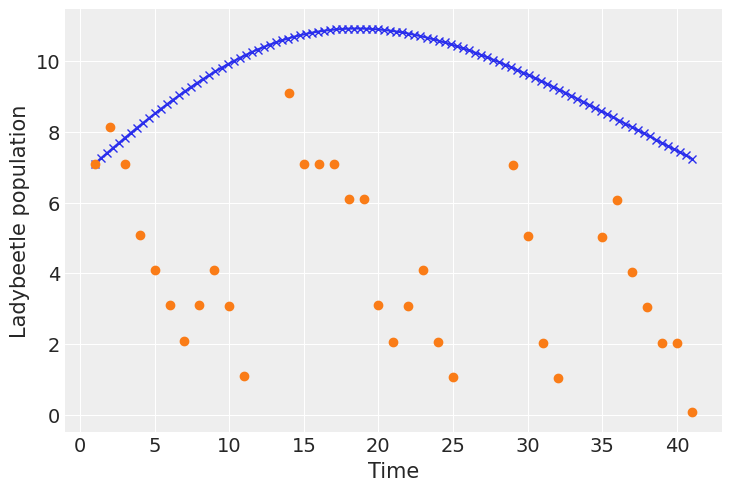

In [52]:
plt.plot(t_computed_LLV, u_LLV, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_LLV, v_LLV, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### SA on Least-Squares objective function

In [53]:
mean_values_params = [
    r_deterministic,
    K_deterministic,
    a_deterministic,
    ef_deterministic,
    m_deterministic,
]
factors_names = [
    r"$r$",
    r"$K$",
    r"$a$",
    r"$ef$",
    r"$m$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [54]:
num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = LLV_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        LLV_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 24/24 [00:00<00:00, 343.89it/s]


In [55]:
data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
$a$,0.439849
$ef$,0.318951
$m$,0.241197
$K$,1.95454e-06
$r$,9.57687e-07


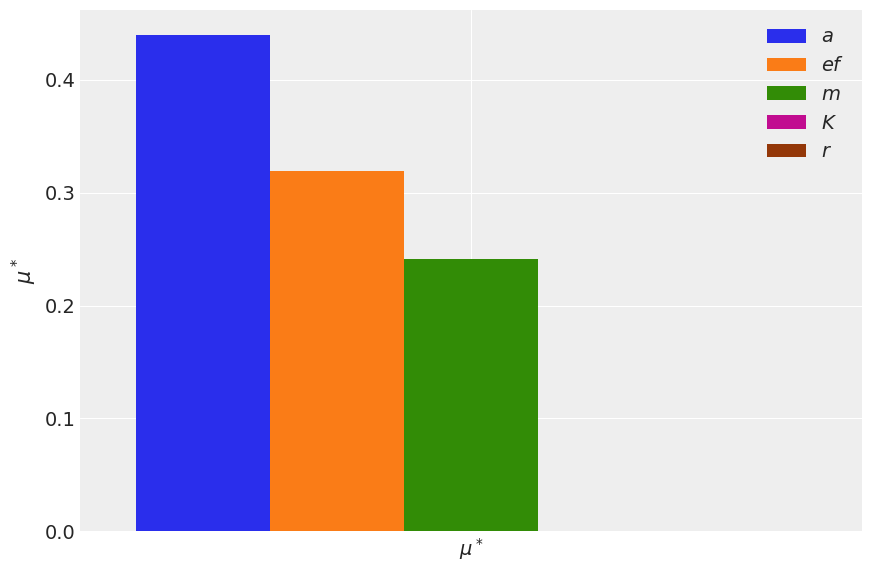

In [56]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("sensitivity_least_squares_LLV.png", dpi=300)
plt.show()

### SA on pest population

In [57]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LLV = LLV_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LLV.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 24/24 [00:00<00:00, 369.15it/s]


In [58]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 294.99it/s]


,Time,$r$,$K$,$a$,$ef$,$m$
0,1.404040,4.58104e-06,6.00635e-06,0.970663,0.0196404,0.00968578
1,1.808081,4.32247e-06,5.68756e-06,0.943504,0.0377396,0.0187466
2,2.212121,4.08724e-06,5.39875e-06,0.918722,0.0541539,0.027115
3,2.616162,3.86809e-06,5.13256e-06,0.895527,0.0697325,0.0347314
4,3.020202,3.6665e-06,4.88901e-06,0.873905,0.0840319,0.0420545
...,...,...,...,...,...,...
94,39.383838,7.31994e-07,1.46085e-06,0.551694,0.243243,0.205061
95,39.787879,7.26491e-07,1.45602e-06,0.550412,0.243625,0.205961
96,40.191919,7.21041e-07,1.45146e-06,0.54914,0.244005,0.206853
97,40.595960,7.15649e-07,1.44704e-06,0.54788,0.244382,0.207736


In [59]:
df_sigmai

,Time,$r$,$K$,$a$,$ef$,$m$
0,1.404040,2.18411e-05,4.29985e-05,0.272574,0.543568,0.183793
1,1.808081,9.96487e-06,2.10748e-05,0.268505,0.545347,0.186117
2,2.212121,6.10123e-06,1.39691e-05,0.266363,0.5456,0.188017
3,2.616162,4.1307e-06,1.03247e-05,0.256752,0.553192,0.190042
4,3.020202,2.91806e-06,8.10292e-06,0.25161,0.555055,0.193323
...,...,...,...,...,...,...
94,39.383838,1.34401e-06,3.149e-06,0.421757,0.311306,0.266932
95,39.787879,1.32106e-06,3.1353e-06,0.42227,0.310354,0.267372
96,40.191919,1.29889e-06,3.12209e-06,0.422764,0.309422,0.267809
97,40.595960,1.27747e-06,3.10964e-06,0.423242,0.308511,0.268243


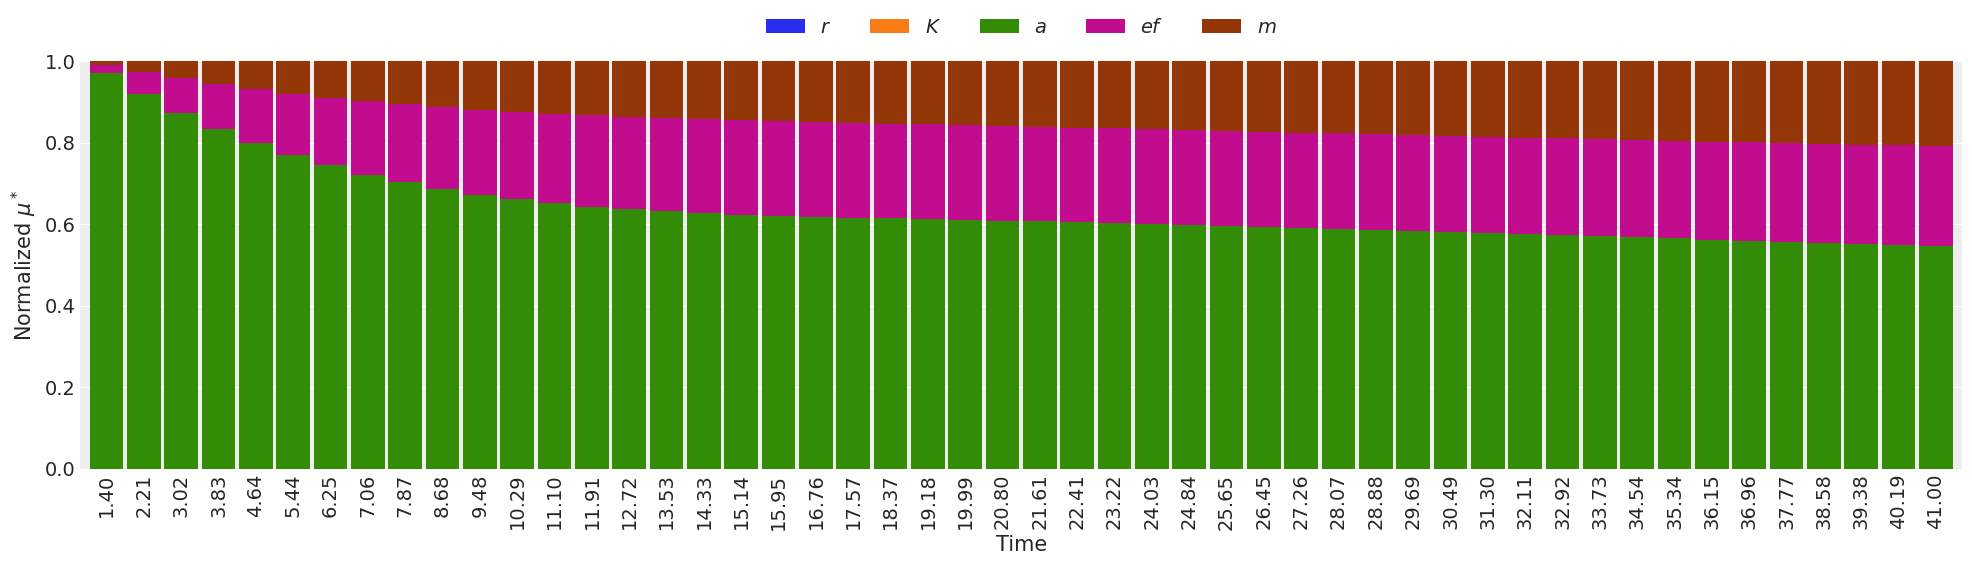

In [60]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_LLV.png", dpi=300)
plt.show()

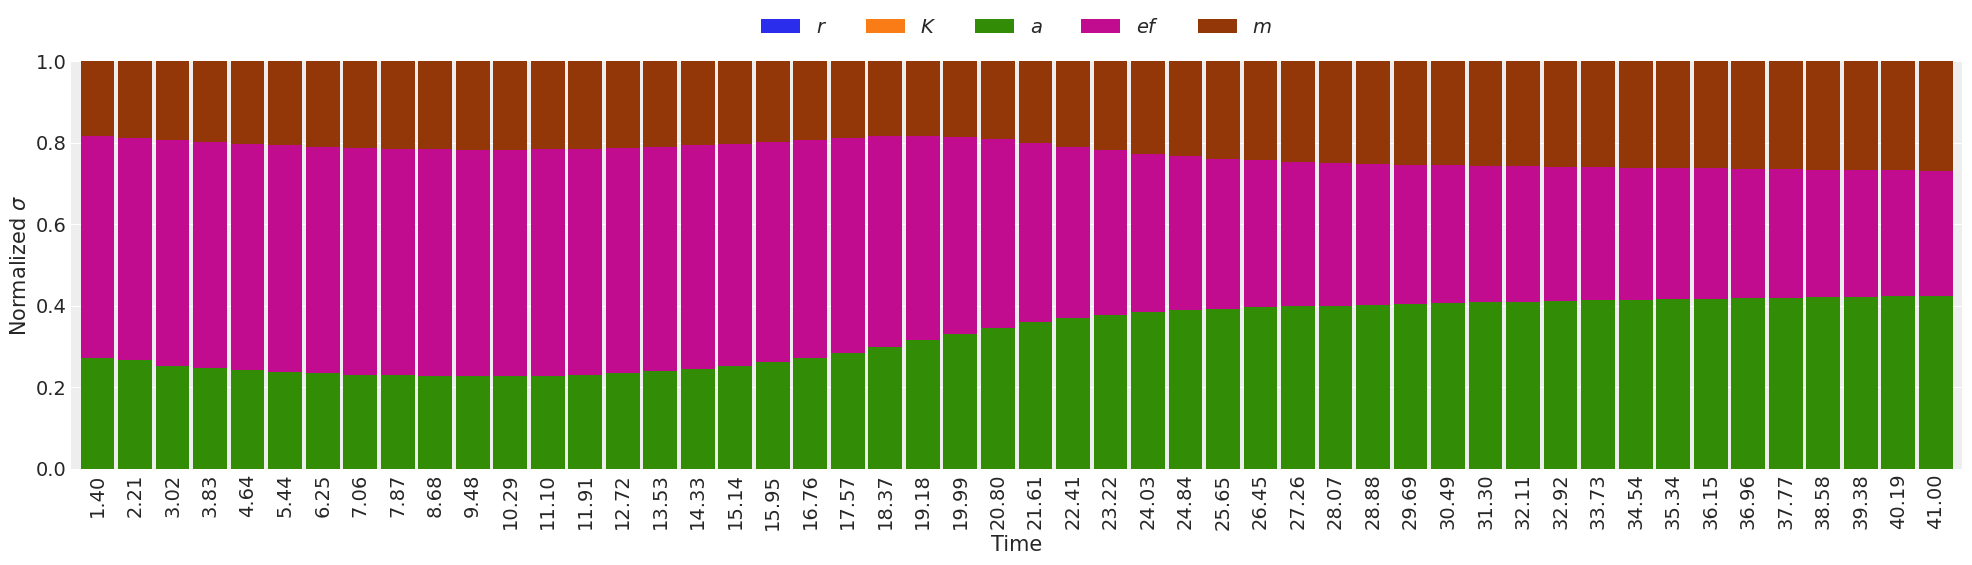

In [61]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma_LLV.png", dpi=300)
plt.show()

### SA on time-derivative pest population

In [62]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_LLV,
    u_LLV,
    v_LLV,
    LLV_model,
    mean_values_params
)

pest_time_derivative_array

array([-67.89901506, -68.49155828, -69.03873875, -69.5391966 ,
       -69.99909006, -70.41109685, -70.76933398, -71.07373951,
       -71.32435553, -71.52132713, -71.66490125, -71.75542536,
       -71.79334592, -71.77920666, -71.71364676, -71.5973987 ,
       -71.43128608, -71.21622117, -70.95320228, -70.64331103,
       -70.28770931, -69.88763619, -69.44440457, -68.95939763,
       -68.4340652 , -67.86991984, -67.26853282, -66.63152984,
       -65.96058667, -65.25742449, -64.52461794, -63.76399517,
       -62.97744907, -62.16714216, -61.33517949, -60.48360869,
       -59.61442001, -58.72954638, -57.83086351, -56.92018998,
       -55.99928732, -55.06986019, -54.13355648, -53.19196749,
       -52.24662809, -51.29901692, -50.35055657, -49.40237998,
       -48.45567684, -47.51227466, -46.57323694, -45.63956106,
       -44.71218056, -43.79196743, -42.87973425, -41.97623645,
       -41.08217437, -40.19819543, -39.32489612, -38.46282409,
       -37.61248011, -36.77432004, -35.94875672, -35.13

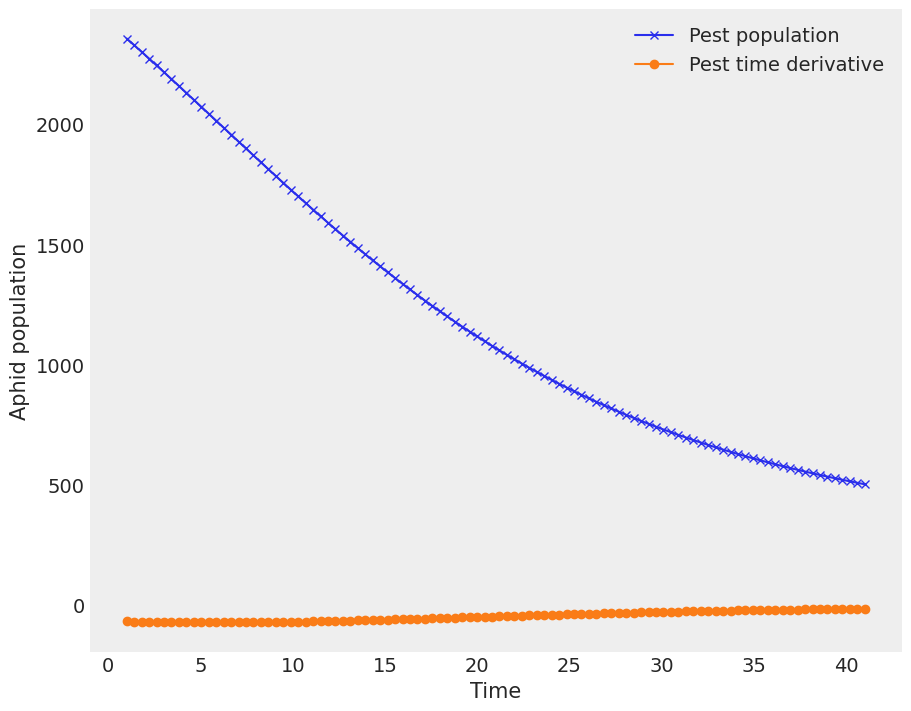

In [63]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_LLV, u_LLV, '-x', label='Pest population')
plt.plot(t_computed_LLV, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("pest_derivative_LLV.png", dpi=300)
plt.show()

In [64]:
for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LLV = LLV_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LLV.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        LLV_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 24/24 [00:00<00:00, 287.24it/s]


In [65]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 294.88it/s]


,Time,$r$,$K$,$a$,$ef$,$m$
0,1.404040,4.32257e-06,5.68681e-06,0.94363,0.0377008,0.0186591
1,1.808081,3.86483e-06,5.12499e-06,0.895227,0.0698271,0.0349374
2,2.212121,3.4725e-06,4.64791e-06,0.853234,0.0974622,0.0492959
3,2.616162,3.13215e-06,4.23824e-06,0.816382,0.121512,0.0620983
4,3.020202,2.83413e-06,3.88345e-06,0.783768,0.142599,0.0736263
...,...,...,...,...,...,...
94,39.383838,1.0598e-06,2.10527e-06,0.345706,0.321543,0.332747
95,39.787879,1.08069e-06,2.12343e-06,0.345818,0.319401,0.334778
96,40.191919,1.10137e-06,2.14207e-06,0.345884,0.317312,0.3368
97,40.595960,1.12182e-06,2.1608e-06,0.345907,0.315274,0.338816


In [66]:
df_sigmai

,Time,$r$,$K$,$a$,$ef$,$m$
0,1.404040,1.00591e-05,2.12222e-05,0.270568,0.544459,0.184941
1,1.808081,4.13692e-06,1.02972e-05,0.264362,0.547126,0.188497
2,2.212121,2.20208e-06,6.70095e-06,0.258639,0.549384,0.191968
3,2.616162,1.30234e-06,4.92832e-06,0.252722,0.551756,0.195516
4,3.020202,8.89728e-07,3.88588e-06,0.247137,0.553793,0.199066
...,...,...,...,...,...,...
94,39.383838,5.67425e-07,1.75718e-06,0.425189,0.277798,0.29701
95,39.787879,5.77643e-07,1.77084e-06,0.42514,0.276378,0.29848
96,40.191919,5.87976e-07,1.78523e-06,0.42501,0.275027,0.299961
97,40.595960,5.98438e-07,1.80012e-06,0.4248,0.273743,0.301455


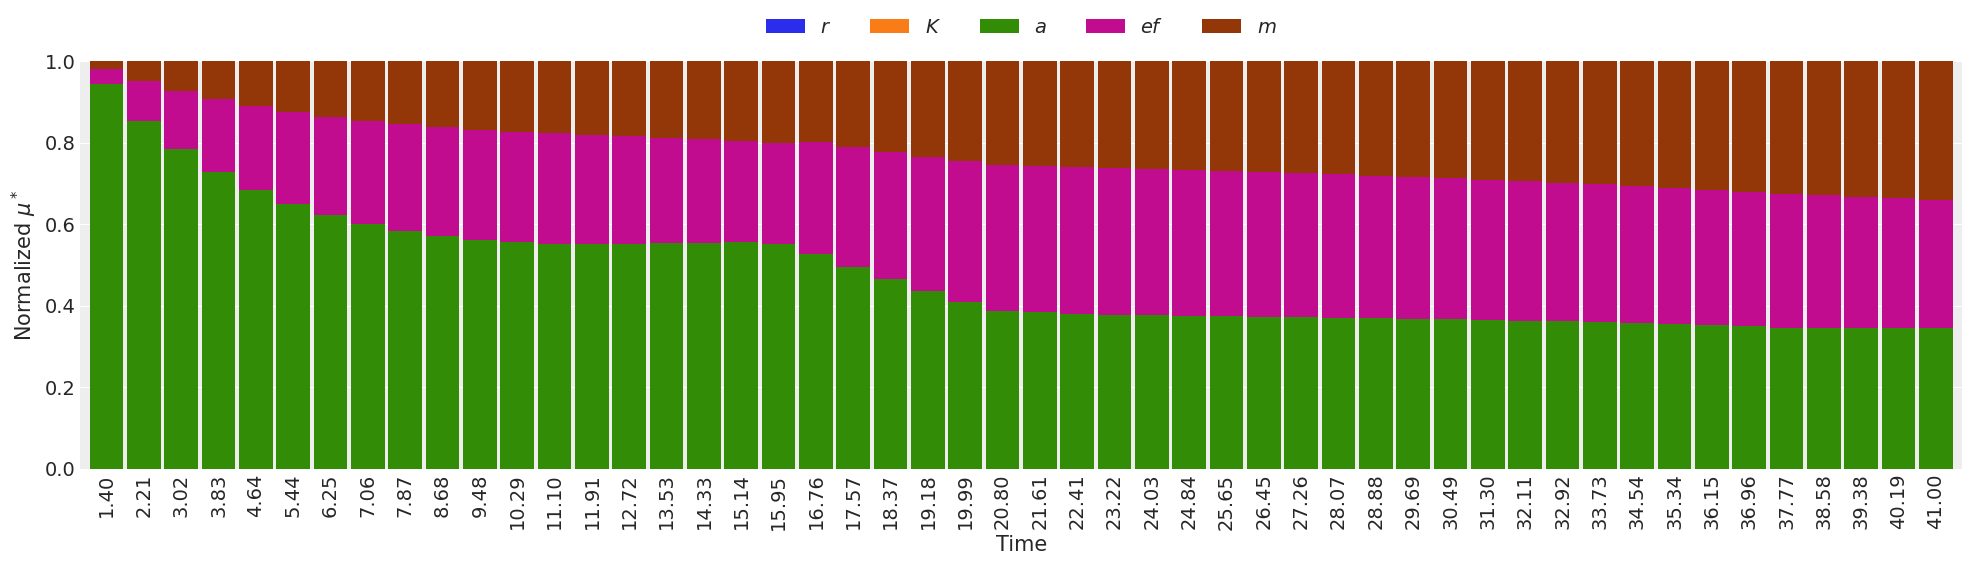

In [67]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_derivative_LLV.png", dpi=300)
plt.show()

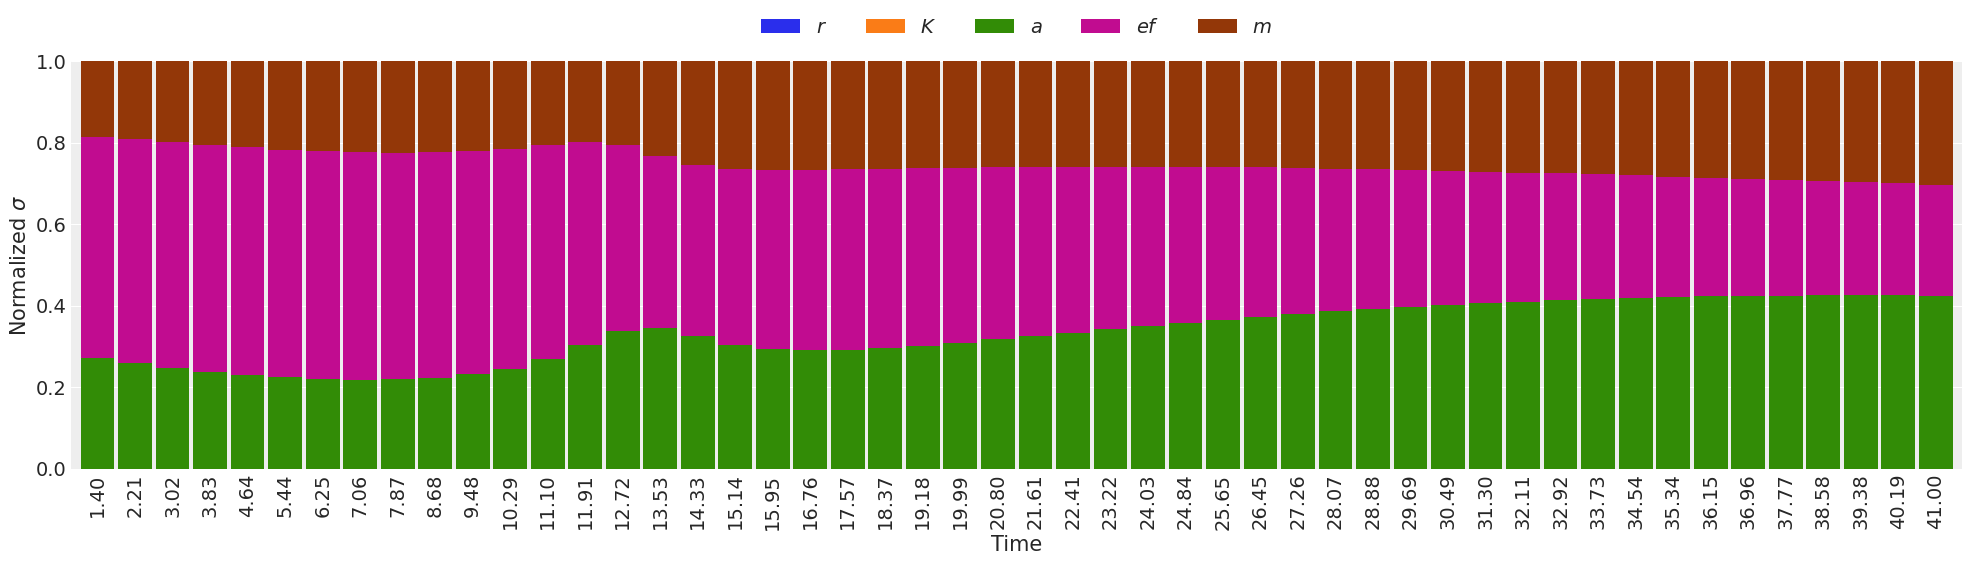

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("SA_pest_pop_sigma_derivative_LLV.png", dpi=300)
plt.show()

## Bayesian calibration

In [69]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r
        t.dscalar,  # K
        t.dscalar,  # a
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def LLV_ode_wrapper(time_exp, r, K, a, ef, m, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r, K, a, ef, m,]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        LLV_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [70]:
observed_aphids_fine = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles_fine = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit_fine = np.vstack([observed_aphids_fine, observed_ladybeetles_fine]).T
time_observations_fine = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_LLV:
    # Prior distributions for the model's parameters
    r_ = pm.Data("r", r_deterministic)  
    K_ = pm.Data("K", K_deterministic)  
    a_ = pm.Uniform(
        "a", 
        lower=(1.0 - percent_calibration) * a_deterministic, 
        upper=(1.0 + 1.5 * percent_calibration) * a_deterministic,
    )
    ef_ = pm.Uniform(
        "ef",
        lower=0, 
        upper=(1.0 + percent_calibration) * ef_deterministic,
    )
    m_ = pm.Uniform(
        "m", 
        lower=(1.0 - percent_calibration) * m_deterministic, 
        upper=(1.0 + percent_calibration) * m_deterministic,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_fine)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LLV_model",
        LLV_ode_wrapper(
            time_calibration,
            r_,
            K_,
            a_,
            ef_,
            m_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_fine
    )


coarse_step = 4
observed_aphids_coarse = observed_aphids_fine[::coarse_step]
observed_ladybeetles_coarse = observed_ladybeetles_fine[::coarse_step]
observations_to_fit_coarse = np.vstack([observed_aphids_coarse, observed_ladybeetles_coarse]).T
time_observations_coarse = time_observations_fine[::coarse_step]
with pm.Model() as coarse_model_LLV:
    # Prior distributions for the model's parameters
    r_ = pm.Data("r", r_deterministic)  
    K_ = pm.Data("K", K_deterministic)  
    a_ = pm.Uniform(
        "a", 
        lower=(1.0 - percent_calibration) * a_deterministic, 
        upper=(1.0 + 1.5 * percent_calibration) * a_deterministic,
    )
    ef_ = pm.Uniform(
        "ef",
        lower=0, 
        upper=(1.0 + percent_calibration) * ef_deterministic,
    )
    m_ = pm.Uniform(
        "m", 
        lower=(1.0 - percent_calibration) * m_deterministic, 
        upper=(1.0 + percent_calibration) * m_deterministic,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LLV_model",
        LLV_ode_wrapper(
            time_calibration,
            r_,
            K_,
            a_,
            ef_,
            m_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse
    )

    
with fine_model_LLV:
    step = pm.MLDA(coarse_models=[coarse_model_LLV], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_LLV = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)
    
duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, m, ef, a]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 96 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 1.864 minutes


In [71]:
calibration_variable_names = [
    "std_deviation",
    "a",
    "ef",
    "m",
]

100%|██████████| 4/4 [00:57<00:00, 14.27s/it]


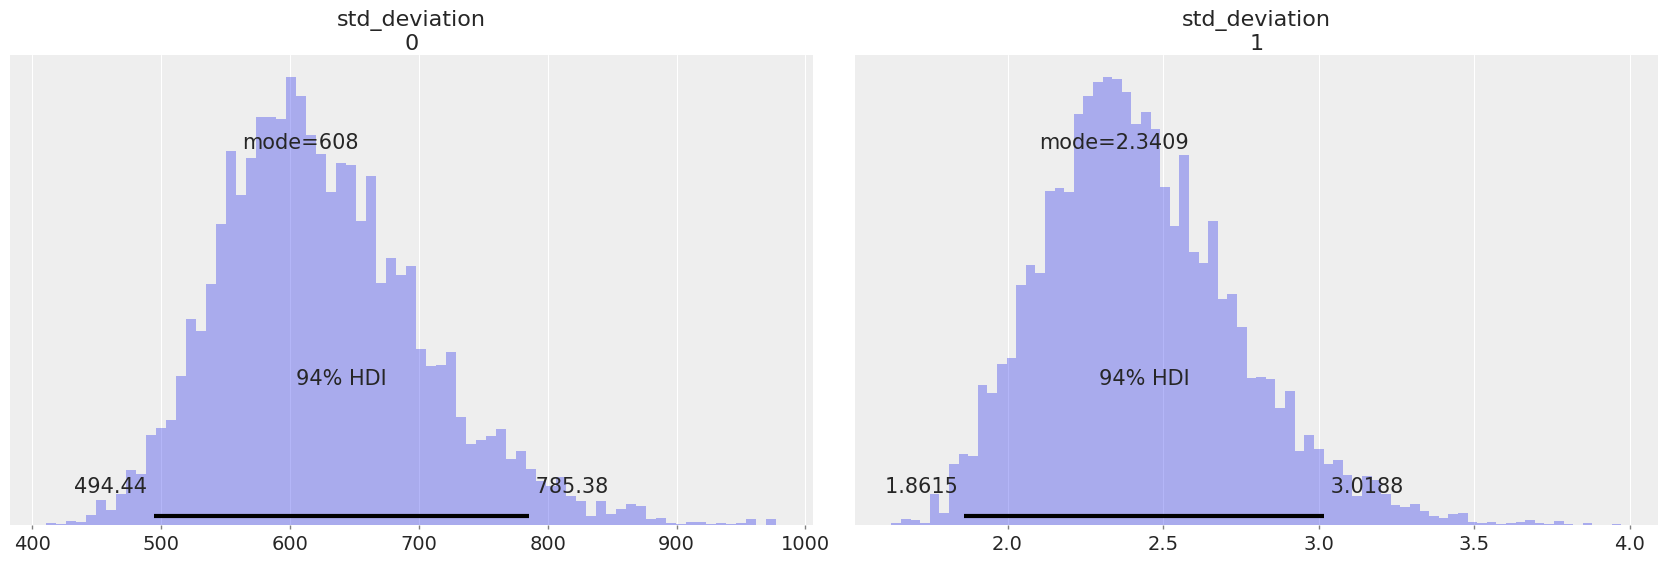

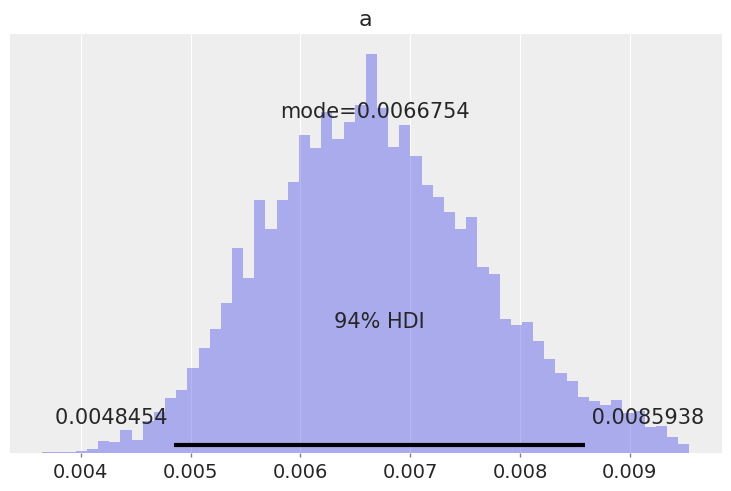

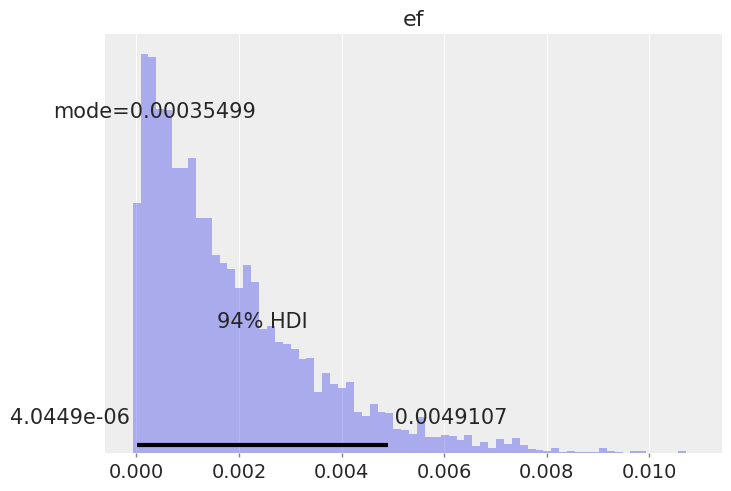

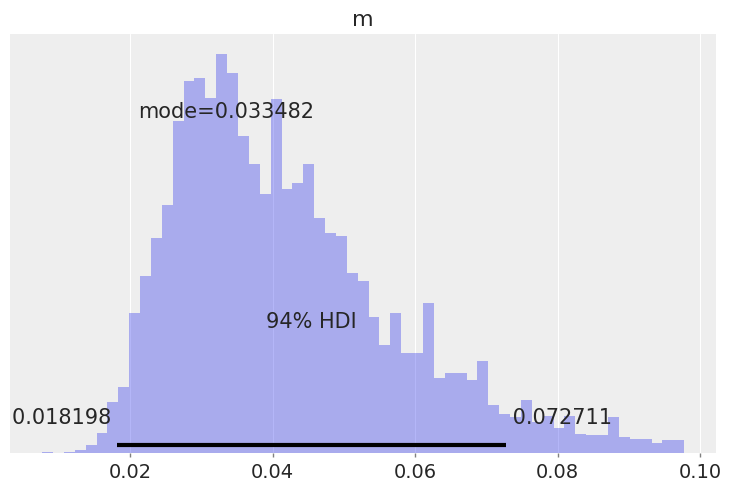

In [72]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_LLV[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"{variable}_posterior_cal_LLV.png")

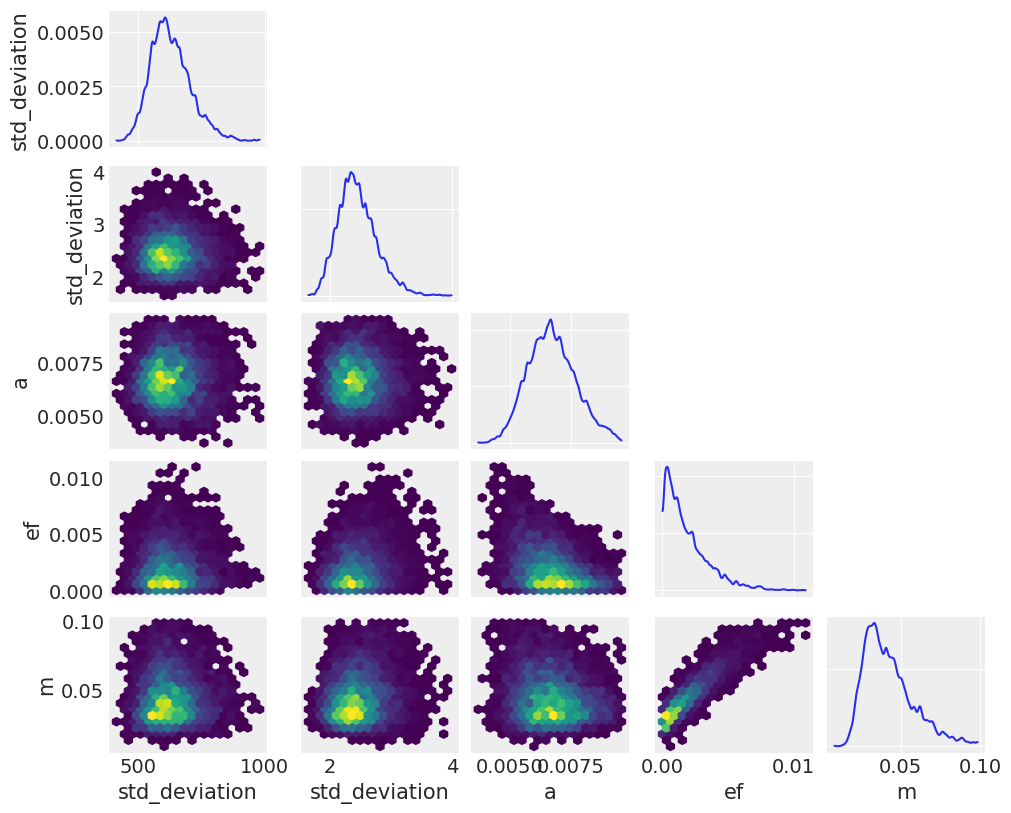

In [73]:
az.plot_pair(
    trace_calibration_LLV,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("marginals_cal_LLV.png")

In [74]:
df_stats_summary = az.summary(
    data=trace_calibration_LLV,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

,mean,sd,hdi_3%,hdi_97%
std_deviation[0],629.824907,78.841804,494.435080,785.384831
std_deviation[1],2.444196,0.314353,1.861499,3.018764
a,0.006737,0.000992,0.004845,0.008594
ef,0.001895,0.001643,0.000004,0.004911
m,0.042862,0.015685,0.018198,0.072711


In [75]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_LLV, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration_LLV.csv")  # salvando em um csv para consultas

df_stats_summary

Calulating MPV from KDE for m: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it]            


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],629.824907,78.841804,494.435080,785.384831,602.573913
std_deviation[1],2.444196,0.314353,1.861499,3.018764,2.346634
a,0.006737,0.000992,0.004845,0.008594,0.006647
ef,0.001895,0.001643,0.000004,0.004911,0.000477
m,0.042862,0.015685,0.018198,0.072711,0.032338


In [76]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_LLV["LLV_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_LLV["LLV_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_LLV["LLV_model"], 50, axis=0)

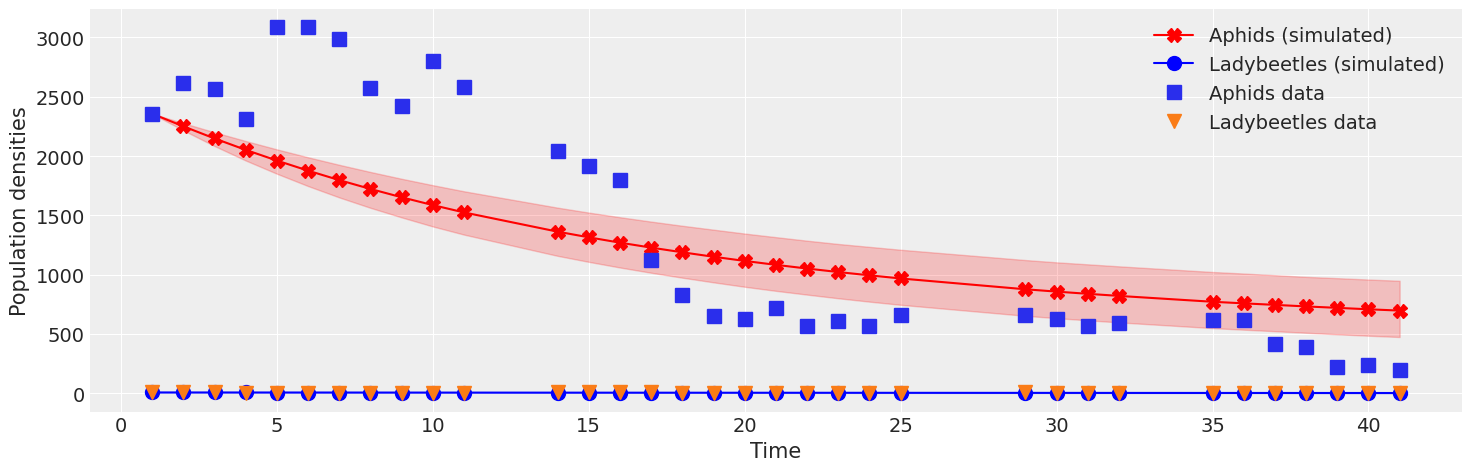

In [77]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("calibration_LLV.png", dpi=300)
plt.show()

In [78]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_LLV.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations_LLV.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering m realizations: 100%|██████████| 3/3 [00:00<00:00, 1686.04it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.072 seconds


In [79]:
df_realizations

,a,ef,m
0,0.006490,0.001146,0.042951
1,0.006490,0.001146,0.042951
2,0.006490,0.001146,0.042951
3,0.006659,0.001440,0.041920
4,0.006499,0.001075,0.035639
...,...,...,...
17995,0.006695,0.000367,0.021804
17996,0.006695,0.000367,0.021804
17997,0.006188,0.000821,0.034787
17998,0.006188,0.000821,0.034787


# Model comparison/selection

## From PyMC3

Check [this example](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html) for further information.

TL;DR: The "score", which is "loo" or "waic" in the printed dataframe bellow, should the greatest for the best model. The `weight` is one of the most important information, because it loosely tell the probability of the model to be the "correct one" among all the compared models.

In [80]:
print("\n*** Performing model comparison ***")
start_time = time.time()

models_to_compare = {
    "BKM": trace_calibration,
    "LLV": trace_calibration_LLV,
}

# Choose ic='loo' or ic='waic'
df_model_comparison = pm.compare(
    models_to_compare, 
    ic='loo',
    method='BB-pseudo-BMA',
    b_samples=3000,
    seed=seed
)

duration = time.time() - start_time

print(f"-- Model comparison done in {duration / 60:.3f} minutes")

df_model_comparison


*** Performing model comparison ***
-- Model comparison done in 0.665 minutes


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BKM,0,-329.854893,3.727184,0.000000,0.979358,17.740909,0.000000,False,log
LLV,1,-345.982391,2.781600,16.127497,0.020642,23.493317,8.044827,False,log


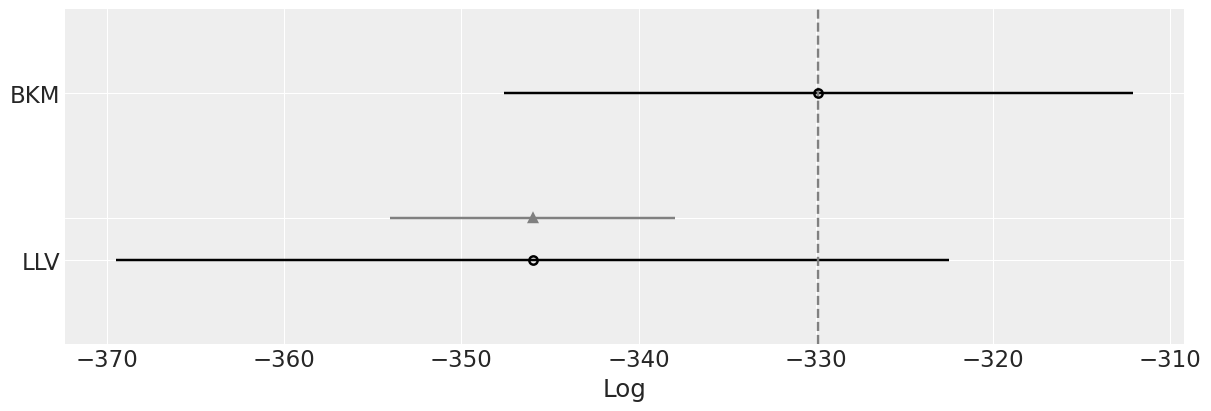

In [81]:
az.plot_compare(df_model_comparison, figsize=(12, 4), insample_dev=False)

plt.show()

## Custom (and basic) information criteria

The criteria employed here are:

* AIC -- Akaike Information Criterion
* BIC -- Bayesian Information Criterion

Both ICs are based on the residual of least squares. This approach has as hypothesis that the error residuals, i.e., $\sum_{i = 1}^n (y^{\text{obs}}_i - y^{\text{model}}_i)^2$, are independent identical normal, with zero mean.

An auxiliary quantity is defined in order to compare the models (relative to the best one):

\begin{equation}
\mathcal{L}^{\text{rel}}_i := \exp{\left(\frac{\text{IC}_{\text{min}} - \text{IC}_i}{2}\right)}
\end{equation}

where $\text{IC}_i$ is the information criterion value (it can be AIC or BIC) for the $i$th model, and $\text{IC}_{\text{min}}$ is the minimum (i.e., the best model) information criterion value from the set of compared models.

This auxiliary quantity is known as "relative likelihood". It is proportional to the probability that the $i$th model minimizes the information loss. For the best model, this value will be always equal to 1.

In [102]:
def calculate_aic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores


def calculate_aicc_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AICc for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        realization_aic_score += 2 * (k * k + k) / (n - k - 1)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores



def calculate_bic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    bic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating BIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_bic_score = k * np.log(n) + n * np.log(total_residual_sum_of_squares / n)
        bic_scores.append(realization_bic_score)

    bic_scores = np.array(bic_scores)
    return bic_scores

In [103]:
aic_scores = calculate_aic_score(trace_calibration, 'BKM_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

Calculating AIC for BKM_model:  39%|███▉      | 7087/18000 [00:02<00:04, 2618.98it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model:  74%|███████▍  | 13355/18000 [00:05<00:01, 2873.32it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model: 100%|██████████| 18000/18000 [00:06<00:00, 2629.72it/s]


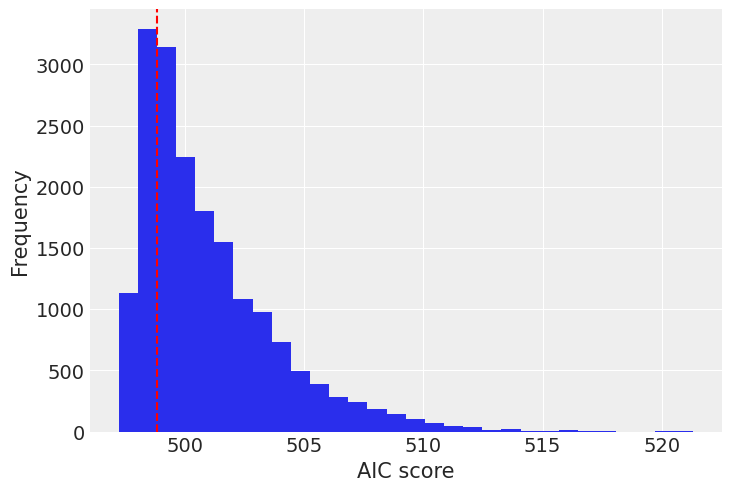

In [104]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [105]:
aicc_scores = calculate_aicc_score(trace_calibration, 'BKM_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

Calculating AICc for BKM_model:  27%|██▋       | 4895/18000 [00:01<00:04, 2757.25it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AICc for BKM_model:  71%|███████   | 12732/18000 [00:04<00:01, 2749.09it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AICc for BKM_model: 100%|██████████| 18000/18000 [00:06<00:00, 2692.15it/s]


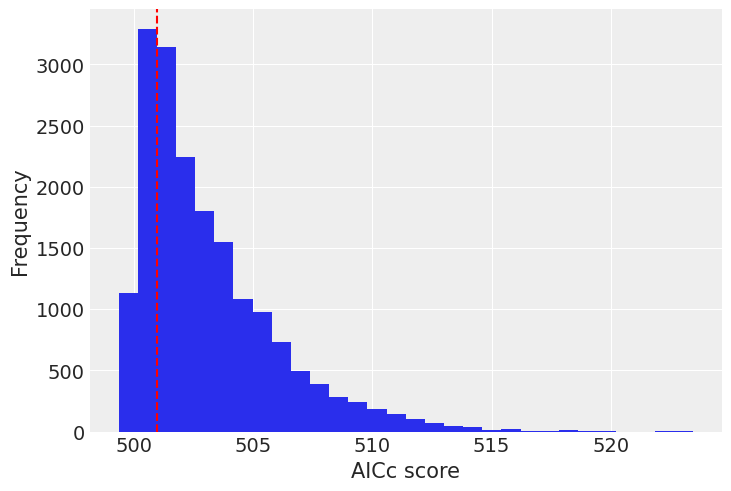

In [106]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [107]:
bic_scores = calculate_bic_score(trace_calibration, 'BKM_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

Calculating BIC for BKM_model:  27%|██▋       | 4870/18000 [00:01<00:04, 2697.67it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating BIC for BKM_model:  63%|██████▎   | 11254/18000 [00:04<00:02, 2691.70it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating BIC for BKM_model:  97%|█████████▋| 17494/18000 [00:06<00:00, 2742.88it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to t

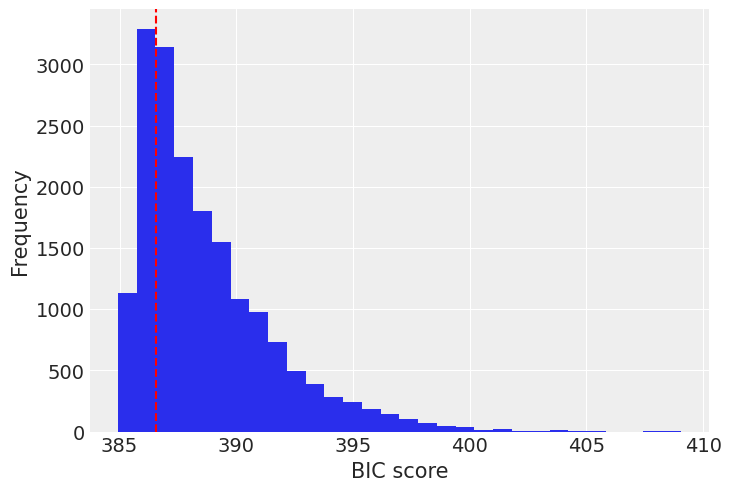

In [108]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

Now we define convenient functions to compare models according to the ICs.

In [109]:
def compare_aic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['model'].append(model_name)
        compare_result['AIC'].append(model_aic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_aicc(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AICc': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['model'].append(model_name)
        compare_result['AICc'].append(model_aicc_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AICc'], ascending=True, inplace=True)
    return df_compare_results


def compare_bic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'BIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['model'].append(model_name)
        compare_result['BIC'].append(model_bic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['BIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_ic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray,
    ic_to_sort: str = 'AIC'
) -> pd.DataFrame:
    # Dict to store results
    compare_result = {
        'model': list(),
        'AIC': list(),
        'AICc': list(),
        'BIC': list(),
    }
    
    # Calculate Information Criteria
    for model_name in models_to_compare:
        compare_result['model'].append(model_name)
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        
        # Compute AIC score
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['AIC'].append(model_aic_mpv)
        
        # Compute AICc score
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['AICc'].append(model_aicc_mpv)
        
        # Compute BIC score
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['BIC'].append(model_bic_mpv)
        
    # Gathering results in a DataFrame
    df_compare_results = pd.DataFrame(compare_result)
    
    # Calculate relative likelihoods
    available_ICs = ['AIC', 'AICc', 'BIC']
    for ic in available_ICs:
        ic_array = np.array(compare_result[ic])
        min_ic_value = ic_array.min()
        ic_relative_likelihoods = np.exp((min_ic_value - ic_array) / 2)
        df_compare_results[f'weight_{ic}'] = ic_relative_likelihoods
            
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=[ic_to_sort], ascending=True, inplace=True)
    return df_compare_results

In [110]:
models_to_compare = {
    # Model names have to be the same as used in PyMC3 sampling
    "BKM_model": trace_calibration,
    "LLV_model": trace_calibration_LLV,
}

# Num of calibrated parameters for each model
models_num_of_parameters = {
    # Model names have to be the same as used in PyMC3 sampling
    "BKM_model": 5,  # r1, p, i, std_1, std_2
    "LLV_model": 5,  # a, ef, m, std_1, std_2
}

df_compare_aic = compare_aic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_aic

Calculating AIC for BKM_model:  27%|██▋       | 4938/18000 [00:01<00:05, 2575.55it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model:  62%|██████▏   | 11182/18000 [00:04<00:02, 2723.02it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model:  97%|█████████▋| 17488/18000 [00:06<00:00, 2828.64it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to t

,AIC
model,
BKM_model,498.808832
LLV_model,565.301999


In [111]:
df_compare_bic = compare_bic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_bic

Calculating BIC for BKM_model:  27%|██▋       | 4832/18000 [00:01<00:05, 2629.76it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating BIC for BKM_model:  62%|██████▏   | 11186/18000 [00:04<00:02, 2529.99it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating BIC for BKM_model:  98%|█████████▊| 17555/18000 [00:06<00:00, 2692.00it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to t

,BIC
model,
BKM_model,386.544376
LLV_model,453.037543


In [112]:
df_compare_ic = compare_ic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_ic

Calculating AIC for BKM_model:  27%|██▋       | 4849/18000 [00:01<00:04, 2732.28it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model:  63%|██████▎   | 11366/18000 [00:04<00:02, 2763.47it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating AIC for BKM_model:  96%|█████████▌| 17307/18000 [00:06<00:00, 2640.79it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to t

,AIC,AICc,BIC,weight_AIC,weight_AICc,weight_BIC
model,,,,,,
BKM_model,498.808832,500.951689,386.544376,1.000000e+00,1.000000e+00,1.000000e+00
LLV_model,565.301999,567.444856,453.037543,3.640762e-15,3.640762e-15,3.640762e-15


In [113]:
df_ic_values = df_compare_ic[['AIC', 'AICc', 'BIC']].T
df_ic_weights = df_compare_ic[['weight_AIC', 'weight_AICc', 'weight_BIC']].T

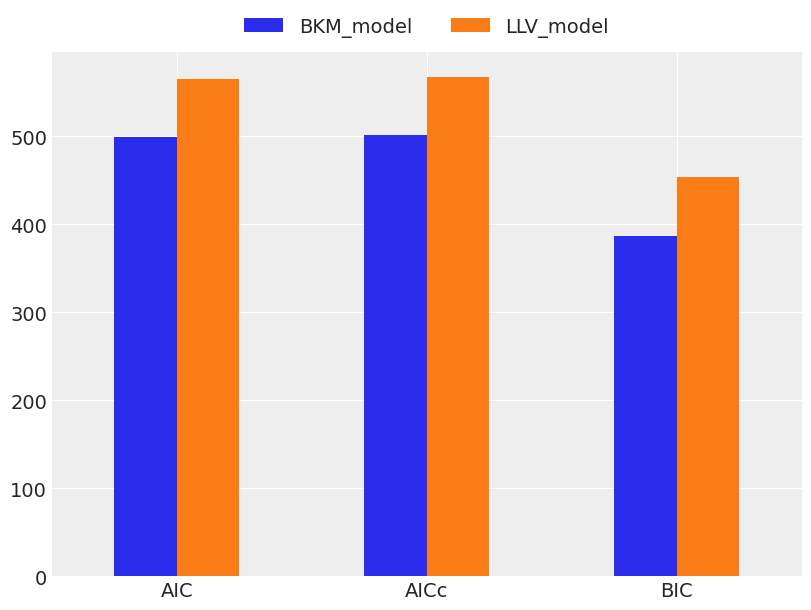

In [114]:
ax = df_ic_values.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

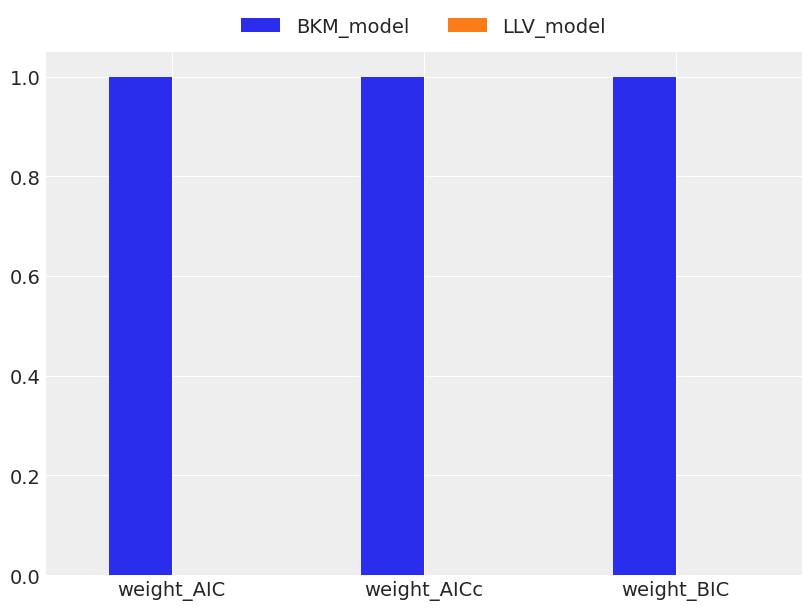

In [115]:
ax = df_ic_weights.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

# Uncertainty propagation

## BKM model

In [116]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast = copy.deepcopy(fine_model)
with fine_model_to_forecast:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration,
        var_names=["BKM_model"],
        random_seed=seed
    )["BKM_model"]  # Should we use likelihood_model or BKM_model?

In [117]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

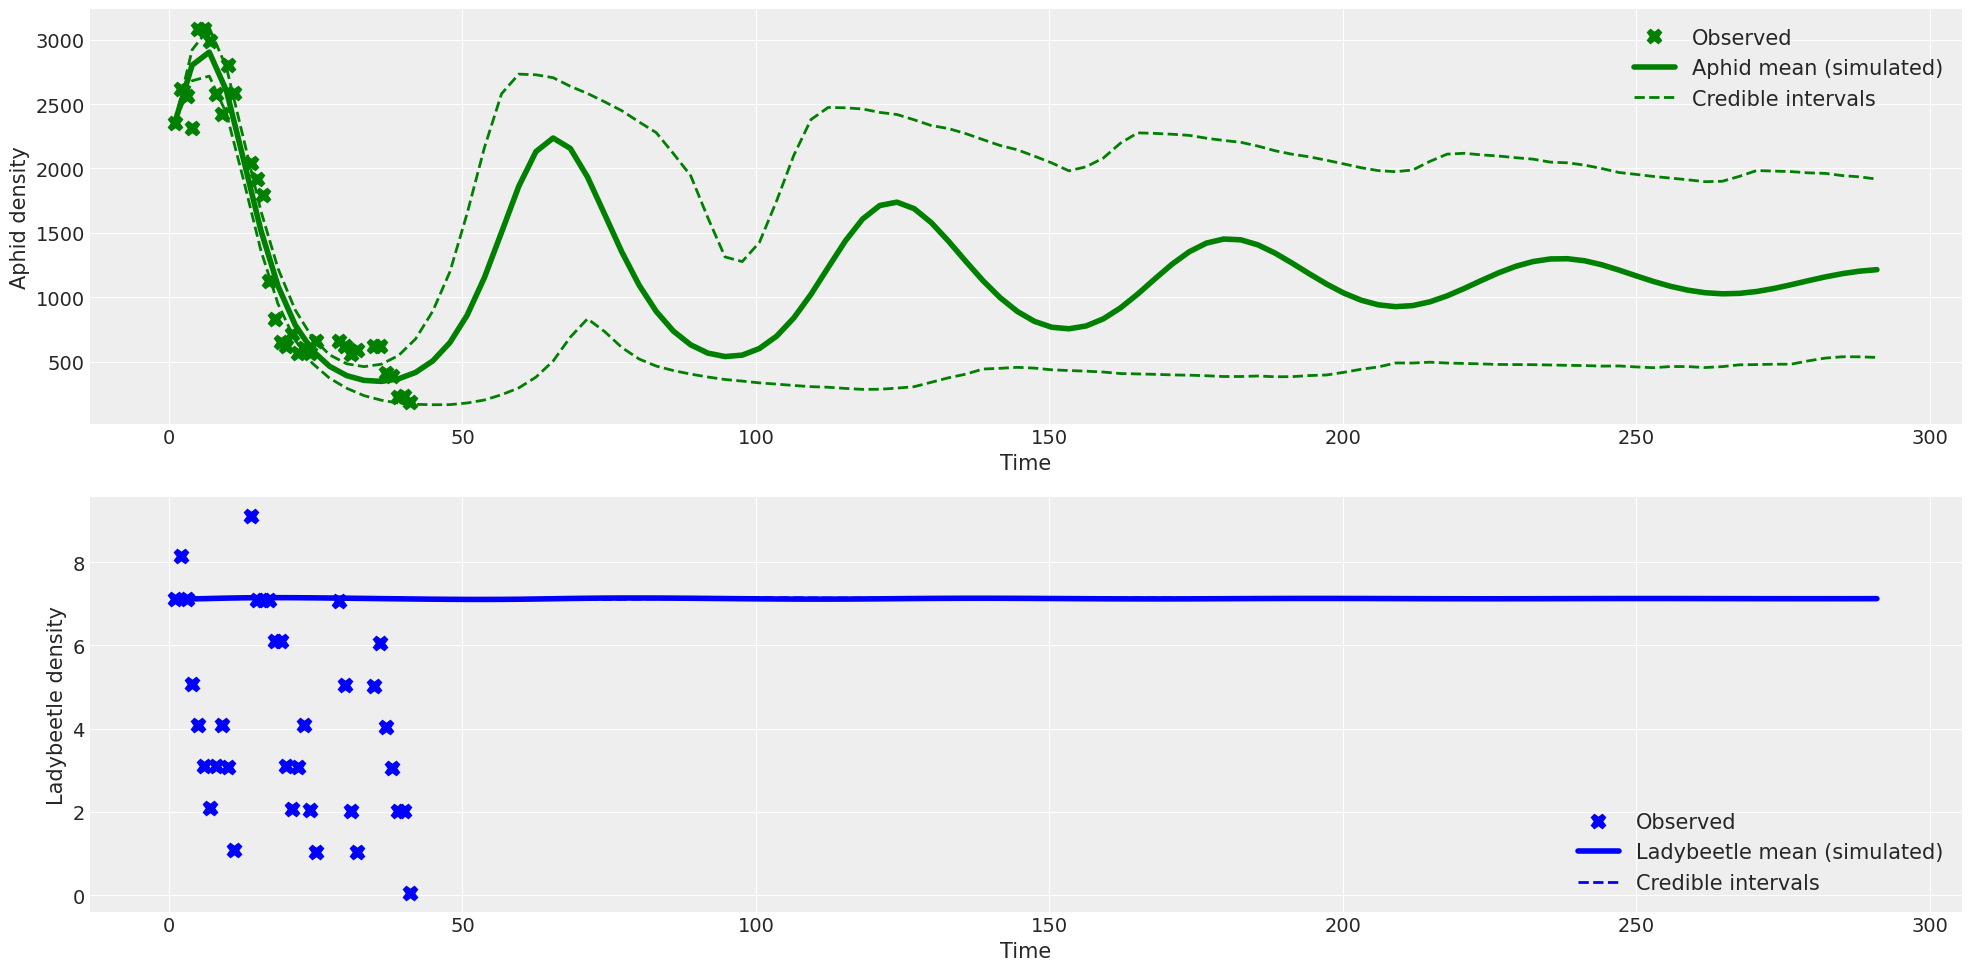

In [118]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("projections.png", dpi=300)
plt.show()

## LLV model

In [119]:
fine_model_to_forecast_LLV = copy.deepcopy(fine_model_LLV)
with fine_model_to_forecast_LLV:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_LLV,
        var_names=["LLV_model"],
        random_seed=seed
    )["LLV_model"]  # likelihood_model or LLV_model?

In [120]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

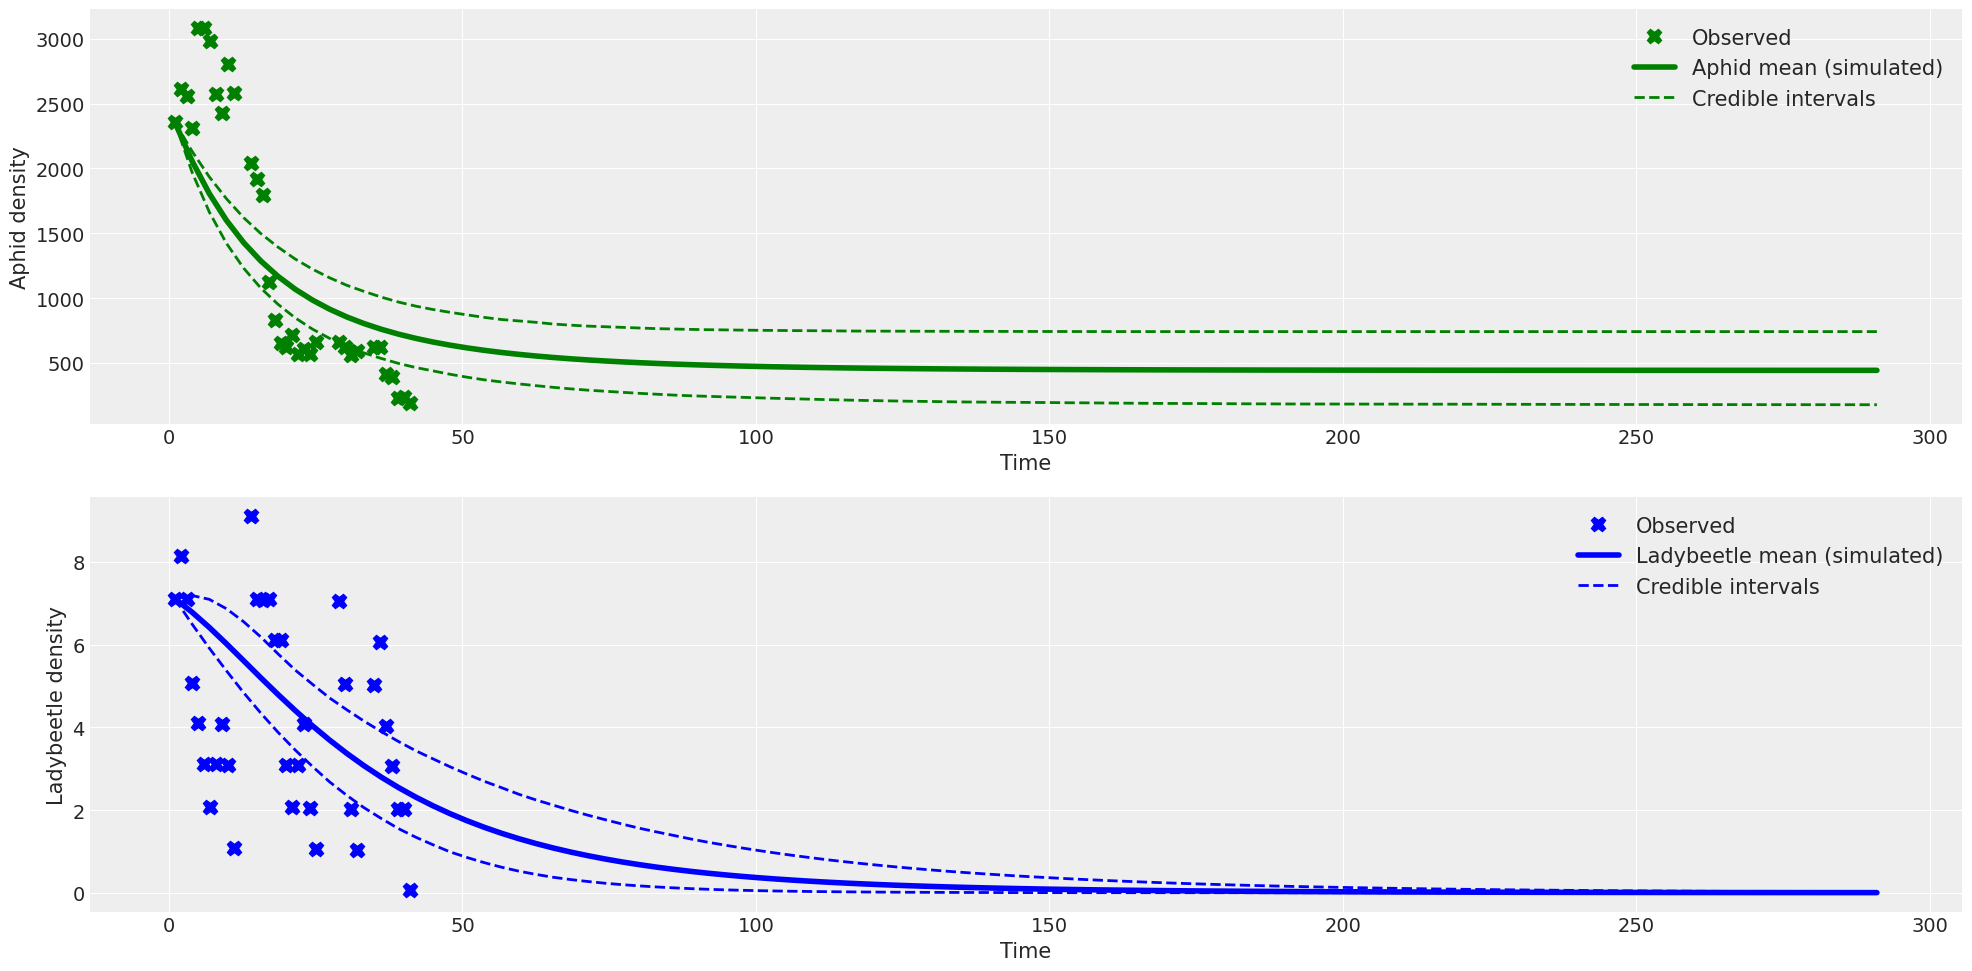

In [121]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("projections_LLV.png", dpi=300)
plt.show()